In [1]:
# -- load data
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as spi
import pandas as pd
import scipy.stats as st
import os
from sklearn.metrics import auc 
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

# -- load parameter values
parameters_file = r'/Users/kowens2/Library/CloudStorage/OneDrive-FredHutchinsonCancerResearchCenter/Monolix/NBA Cohort/Projects/FitAllInfectionsAppendNegatives/T0_1x107_E0_0_I0_0_V0_est/IndividualParameters/estimatedIndividualParameters.txt'
parameters_df = pd.read_csv(parameters_file)

# load data for well-documented infections into data frame
data_file = r'/Users/kowens2/Documents/SARS-CoV-2 Rebound/NBACohortMay2023/DataPreProcessing/NBA_6Clusters_810infections.xlsx'
data_df = pd.read_excel(data_file)
IDs_clustered = list(data_df.ID.unique())

# -- transfer cluster results to parameters_df
clusters2 = []
for ID in parameters_df.id.unique(): 
    if ID in list(data_df.ID):
        cluster2 = list(data_df[data_df['ID']==ID].Cluster)[0]
        clusters2.append(cluster2)
    else:
        clusters2.append(10)
parameters_df['Cluster'] = clusters2

# -- load data for all infections
full_data_file = r'/Users/kowens2/Library/CloudStorage/OneDrive-FredHutchinsonCancerResearchCenter/Monolix/NBA Cohort/Data/NBA_1510infections.csv'
full_data_df = pd.read_csv(full_data_file)

def GetParams(parameters_df, ID, style = 'mode'):
    ''' 
    input:
        - data frame with parameter values as columns, individuals as rows
        - ID identifying individual of interest
        - style = 'mode' or 'mean' or 'SAEM' depending on which parameter values are preferred
    return:
        - dictionary with parameter names as key and parameter values as values
    '''
    i = ID
    cols = list(parameters_df)
    pid_params = parameters_df[parameters_df.id == i].copy()
    values = []
    keys = []
    for c in cols:
        if style in c:
            k = c.split('_')[0]
            keys.append(k)
            v = pid_params[c].values[0]
            values.append(v)
        for i,(v,k) in enumerate(zip(values, keys)):
            if 'log10' in k:
                values[i] = 10**v
                keys[i] = k.split('0')[1]

    params = dict(zip(keys, values))
    return params

def Simulate(func, param_order, param_dict, init, tend, N):
    '''
    input: 
        - func is a function that takes in the state variable, time and parameters and returns the derivative
        - params is a dictionary of the parameter values 
        - init is a dictionary of the initial condition to simulate from 
    return: 
        - trajectory simulated from init for tspan using func with given params
    '''
    # make parameter list in correct order
    params = []
    for k in param_order:
        params.append(param_dict[k])
    # extract initial time
    if 'tzero' in param_dict:
        t0 = -param_dict['tzero']
    else:
        t0 = 0 
    # build tspan
    tspan = np.linspace(t0,tend,N)
    # incorporate V0
    V0 = param_dict['V0']
    init[4] = V0
    # simulate using scipy integrate
    y = spi.odeint(func, init, tspan, args = tuple(params))
    return tspan,y

# Put fixed paramters in a dictionary
fixed_params = dict({'c': 15, 'k':4})
T_0 = 10**7
R_0 = 0;
E_0 = 0;
I_0 = 0;
V_0 = 0;
init = [T_0, R_0, E_0, I_0, V_0]

# Write function for model simulation
def deriv(y, t, beta, phi, rho, k, delta,h, m, pi, c,tAI):
    T,R,E,I,V = y
    
    if t > tAI:
        eps = m
    else:
        eps = 0
        
    ddt_T = -beta*T*V - phi*I*T + rho*R
    ddt_R = phi*I*T -rho*R
    ddt_E = beta*T*V - k*E
    ddt_I = k*E - delta*np.maximum(I,.000001)**h*I - eps*I
    if I >=1:
        ddt_V = pi*I-c*V
    else:
        ddt_V = -c*V


    return ddt_T, ddt_R, ddt_E, ddt_I, ddt_V

param_order = ['beta', 'phi', 'rho', 'k', 'delta','h', 'm', 'pi', 'c', 'tAI']

# -- color dictionary for plotting
colorDict = {0:'cornflowerblue',1:'forestgreen', 2:[230/255,195/255,0],3:[220/255,100/255,0],4: 'firebrick',5: 'indigo', 10: 'k'}

In [3]:
# -- Simulate and flag rebound infections
from scipy.signal import find_peaks

numpeaks = []
time_last_peak = []
N = 5000
for i in parameters_df.id.unique():
    ind_params = GetParams(parameters_df, i, style = 'SAEM')
    params_dict = {**fixed_params, **ind_params}
    tzero = -params_dict['tzero']
    t,y = Simulate(deriv, param_order, params_dict, init, 50+tzero, N);
    t = t - t[0]
    I = y[:,3]
    V = y[:,4]
    peaks, props = find_peaks(np.log10(np.maximum(V,200)), height = 3, prominence = 1)
    numpeaks.append(len(peaks))
    if len(peaks) > 1:
        time_last_peak.append(t[peaks[-1]])
    else:
        time_last_peak.append(t[peaks])

parameters_df['NumPeaks'] = numpeaks
parameters_df['TimeToLastPeak'] = time_last_peak
thresh = np.median(parameters_df[parameters_df['NumPeaks']>1].TimeToLastPeak)

ReboundGroups = []
for num, time in zip(numpeaks, time_last_peak):
    if num <=1:
        ReboundGroups.append(0)
    else:
        ReboundGroups.append(1)
        
parameters_df['Rebound'] = ReboundGroups

In [4]:
# Put all the rebound cases in the front
IDs_rebound = parameters_df[parameters_df['Rebound']>0].id.unique()
IDs_nonrebound = parameters_df[parameters_df['Rebound']<1].id.unique()

# Sort by identifier so that infections in the same individual will be next to eachother 
# (unless one is rebound and one isn't)
IDs_rebound.sort()
IDs_nonrebound.sort()
IDs_total = np.concatenate((IDs_rebound,IDs_nonrebound))

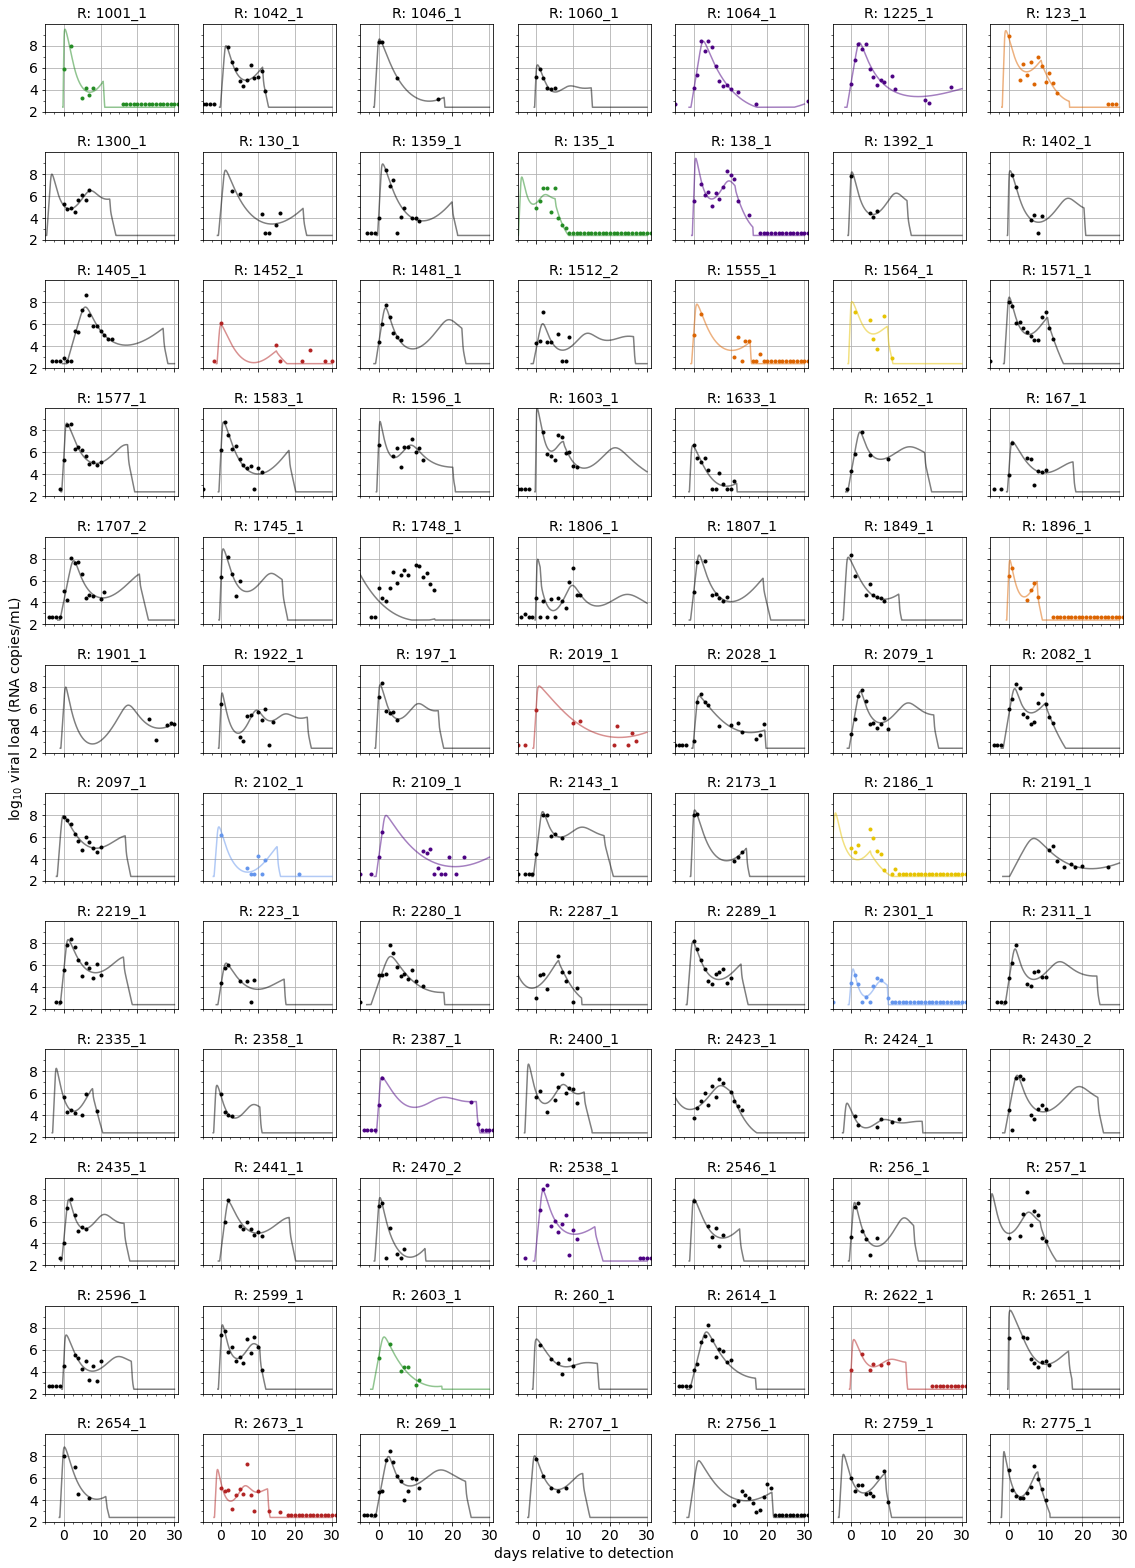

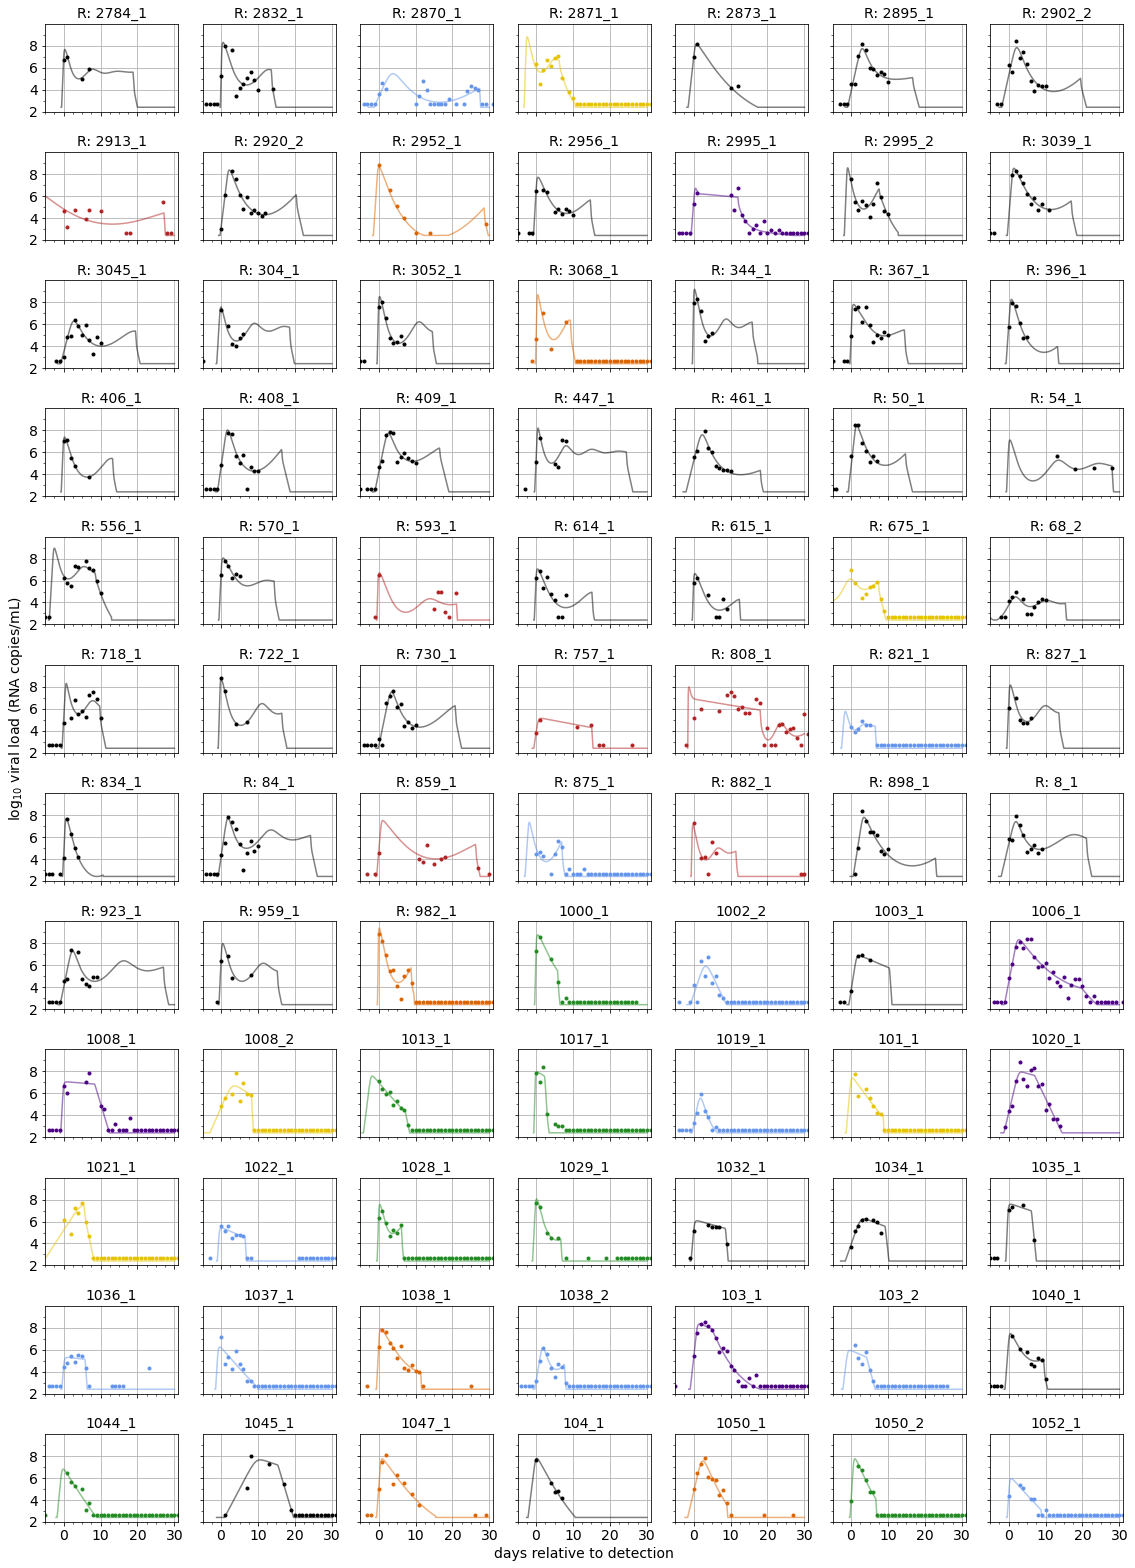

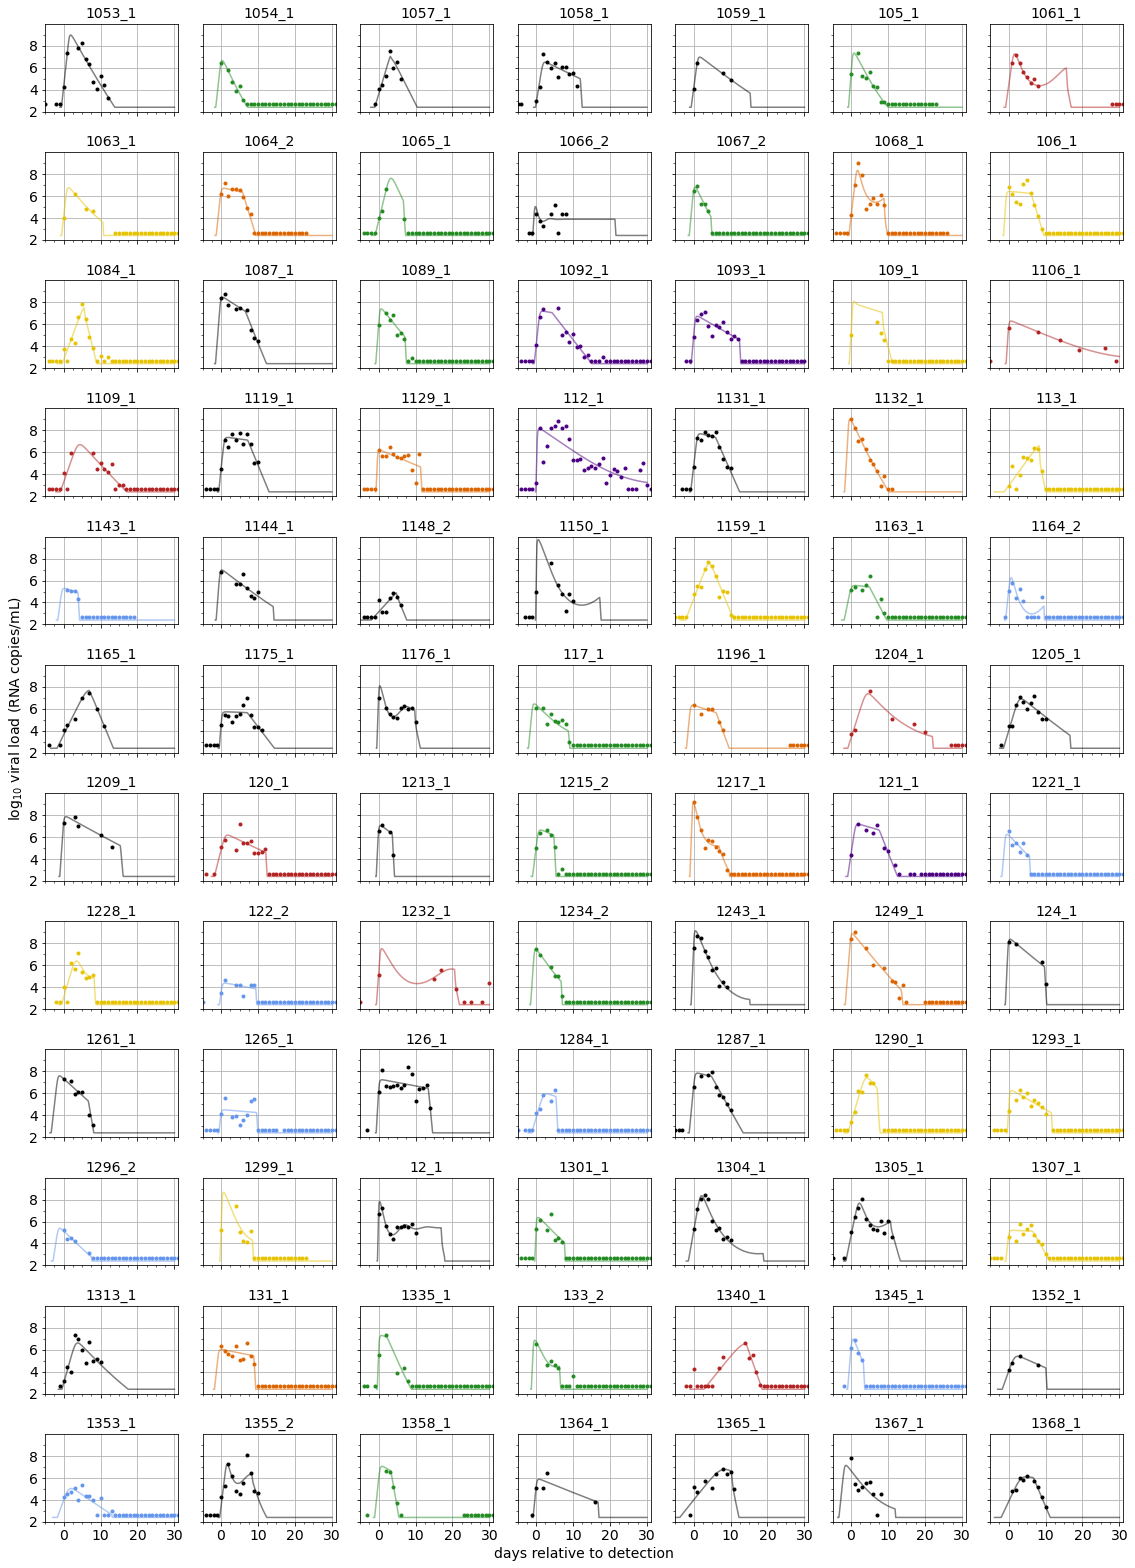

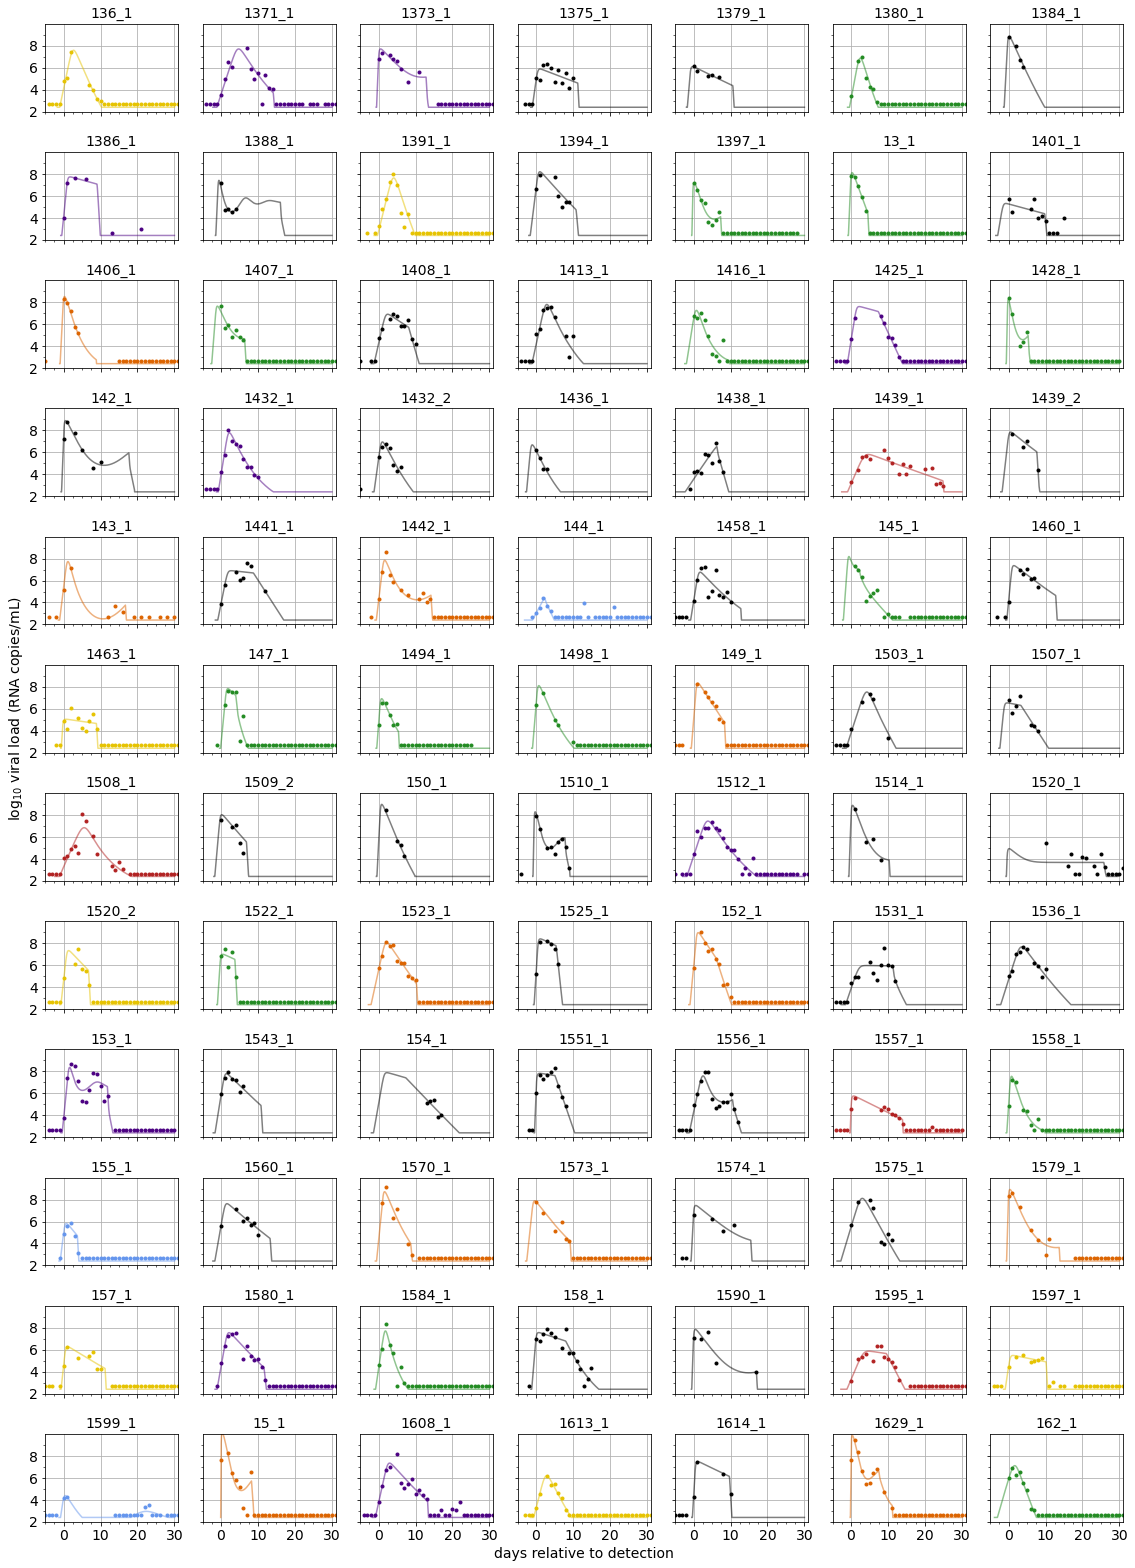

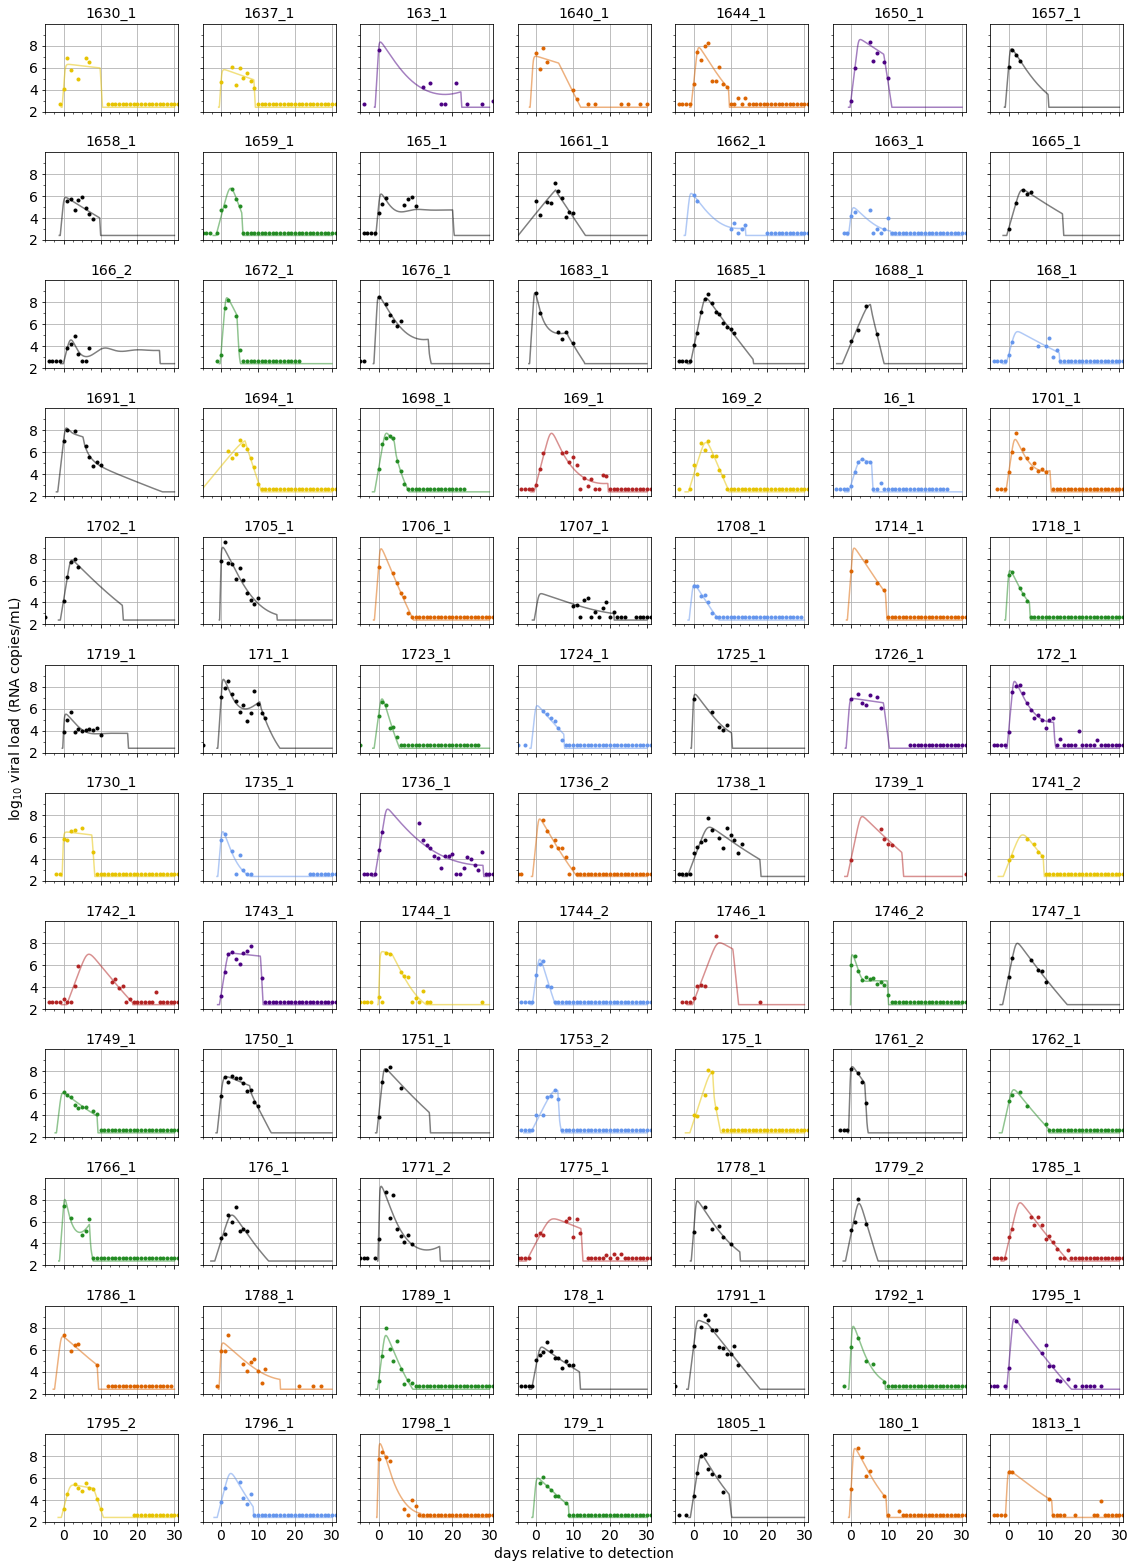

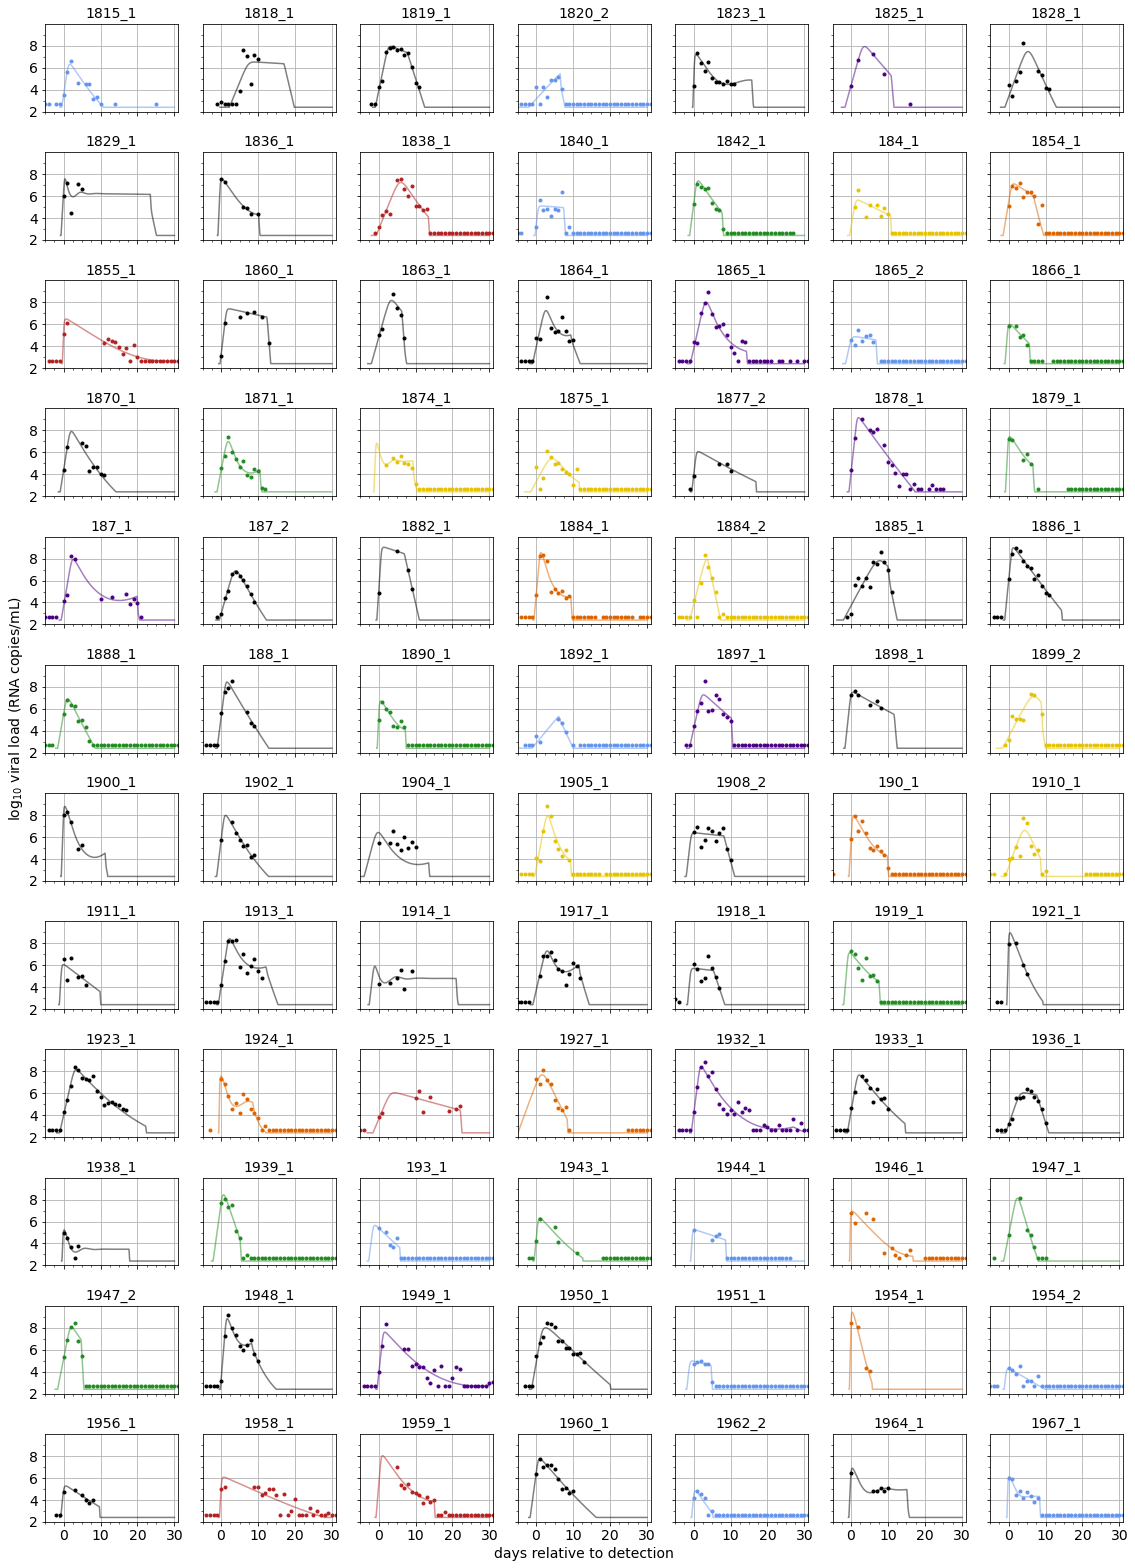

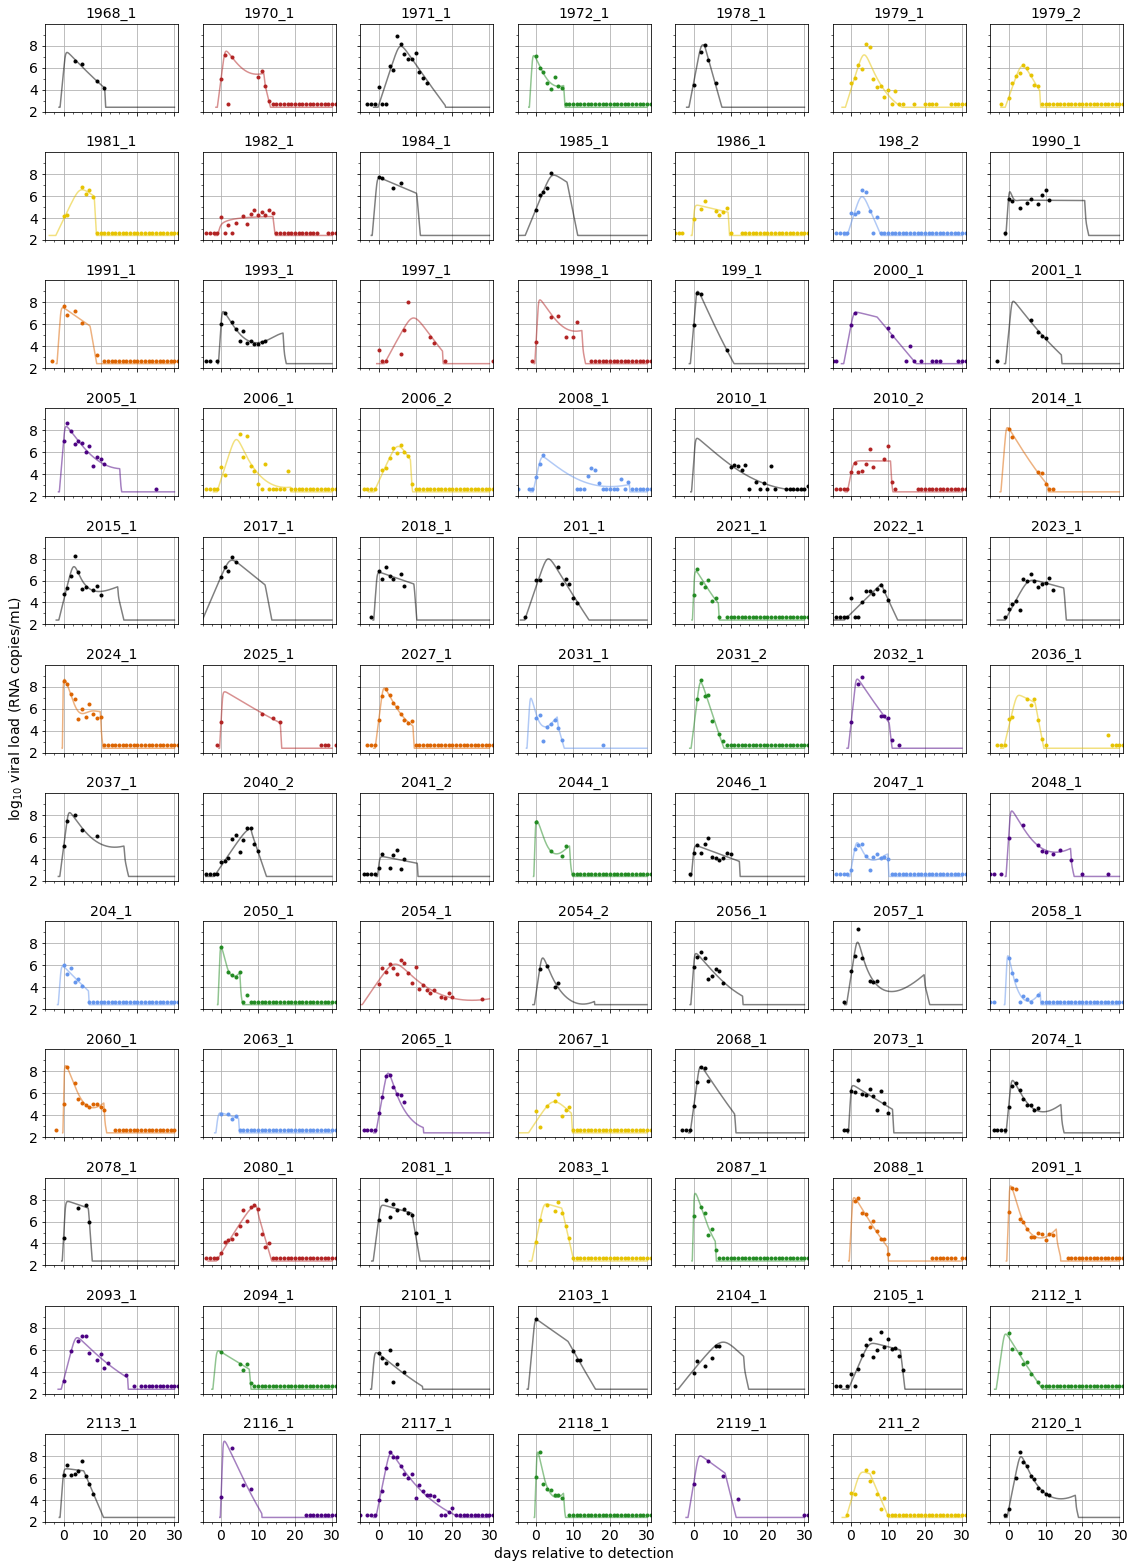

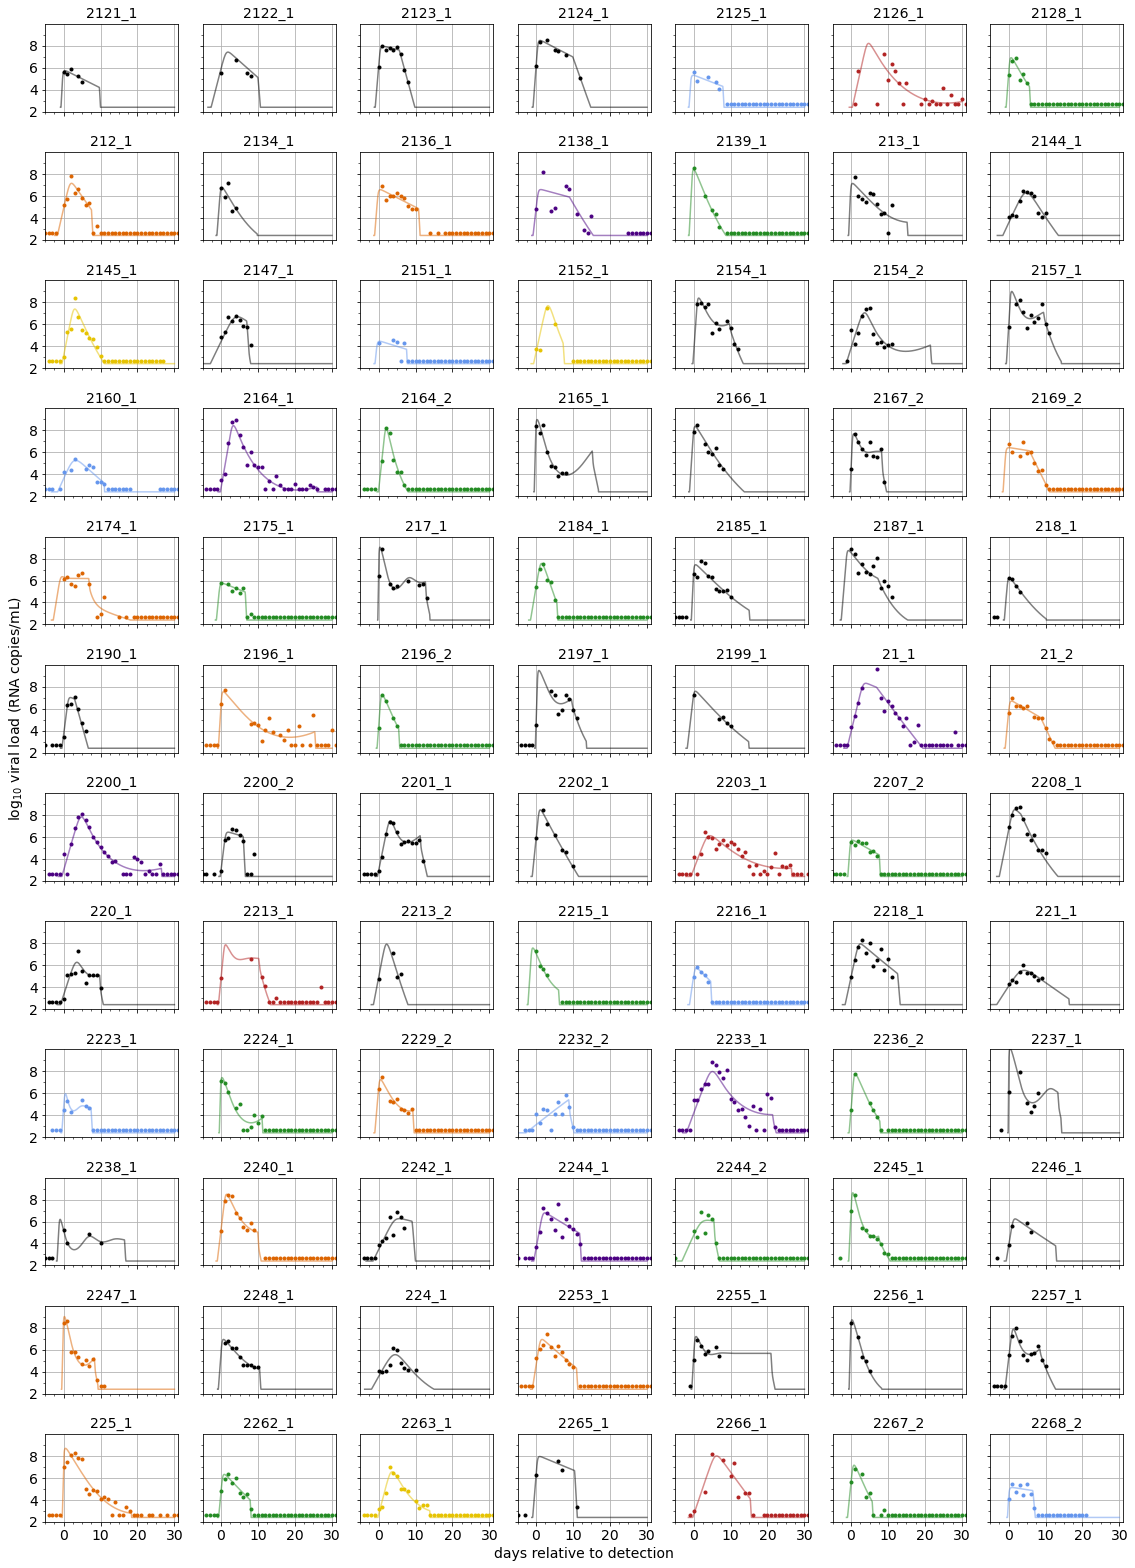

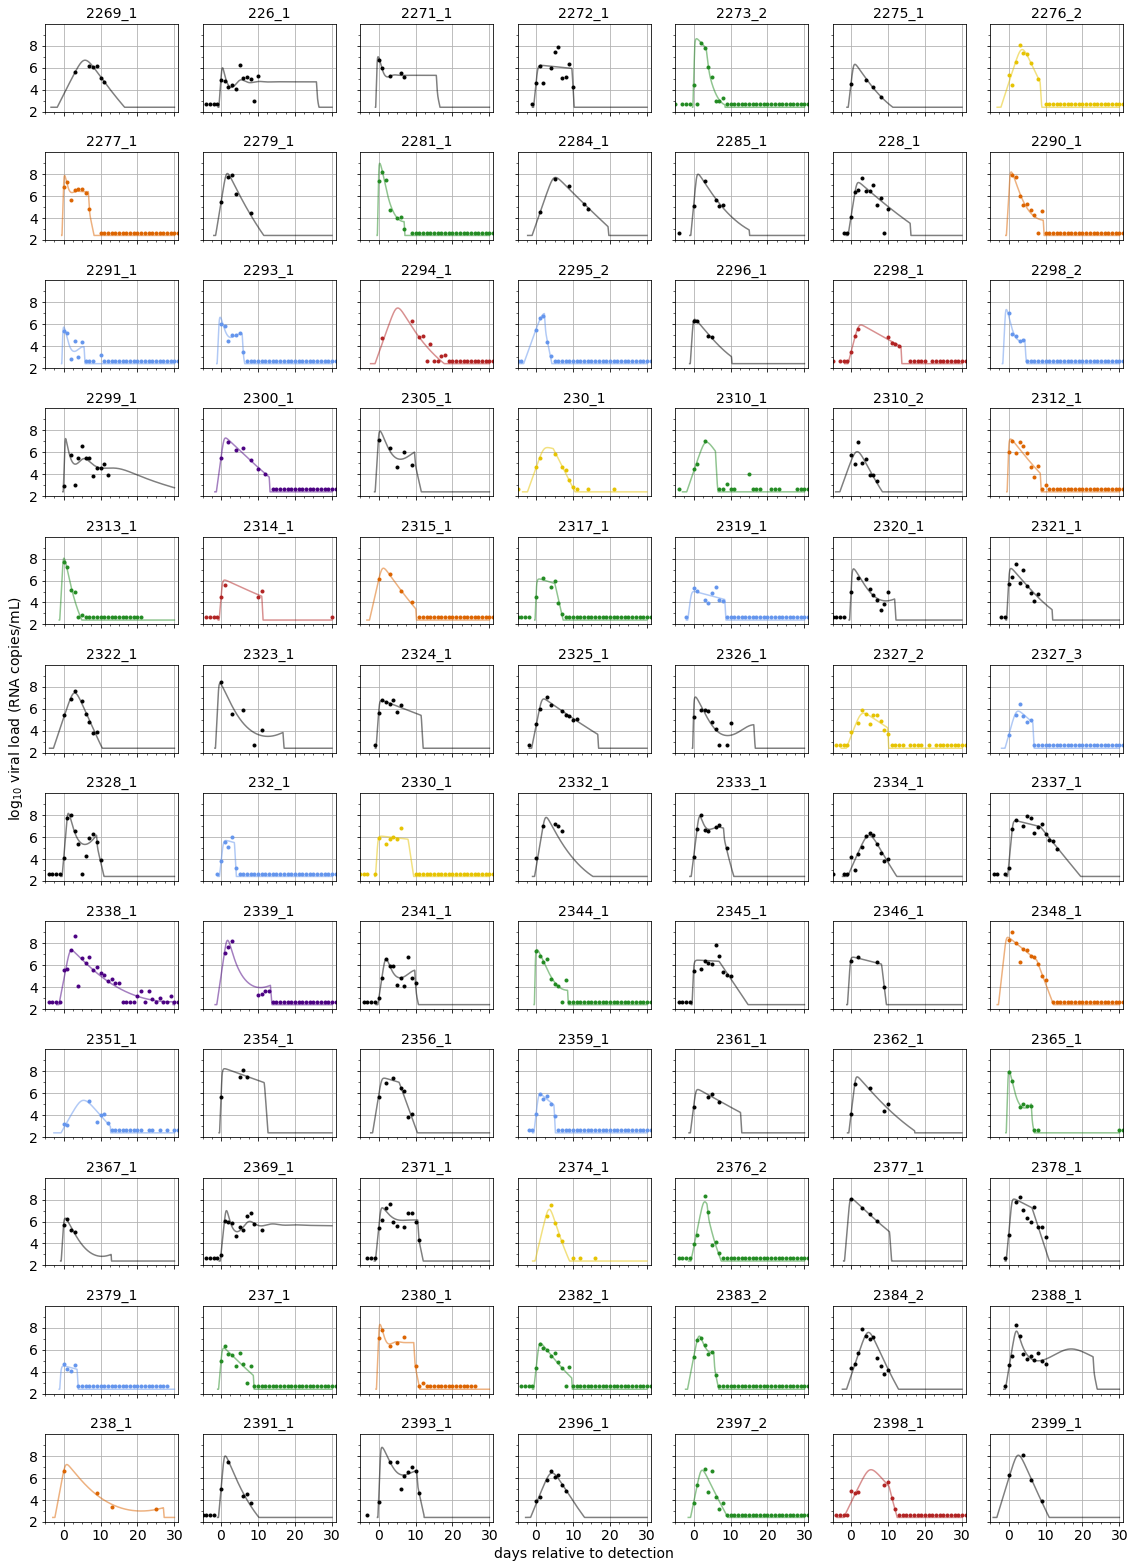

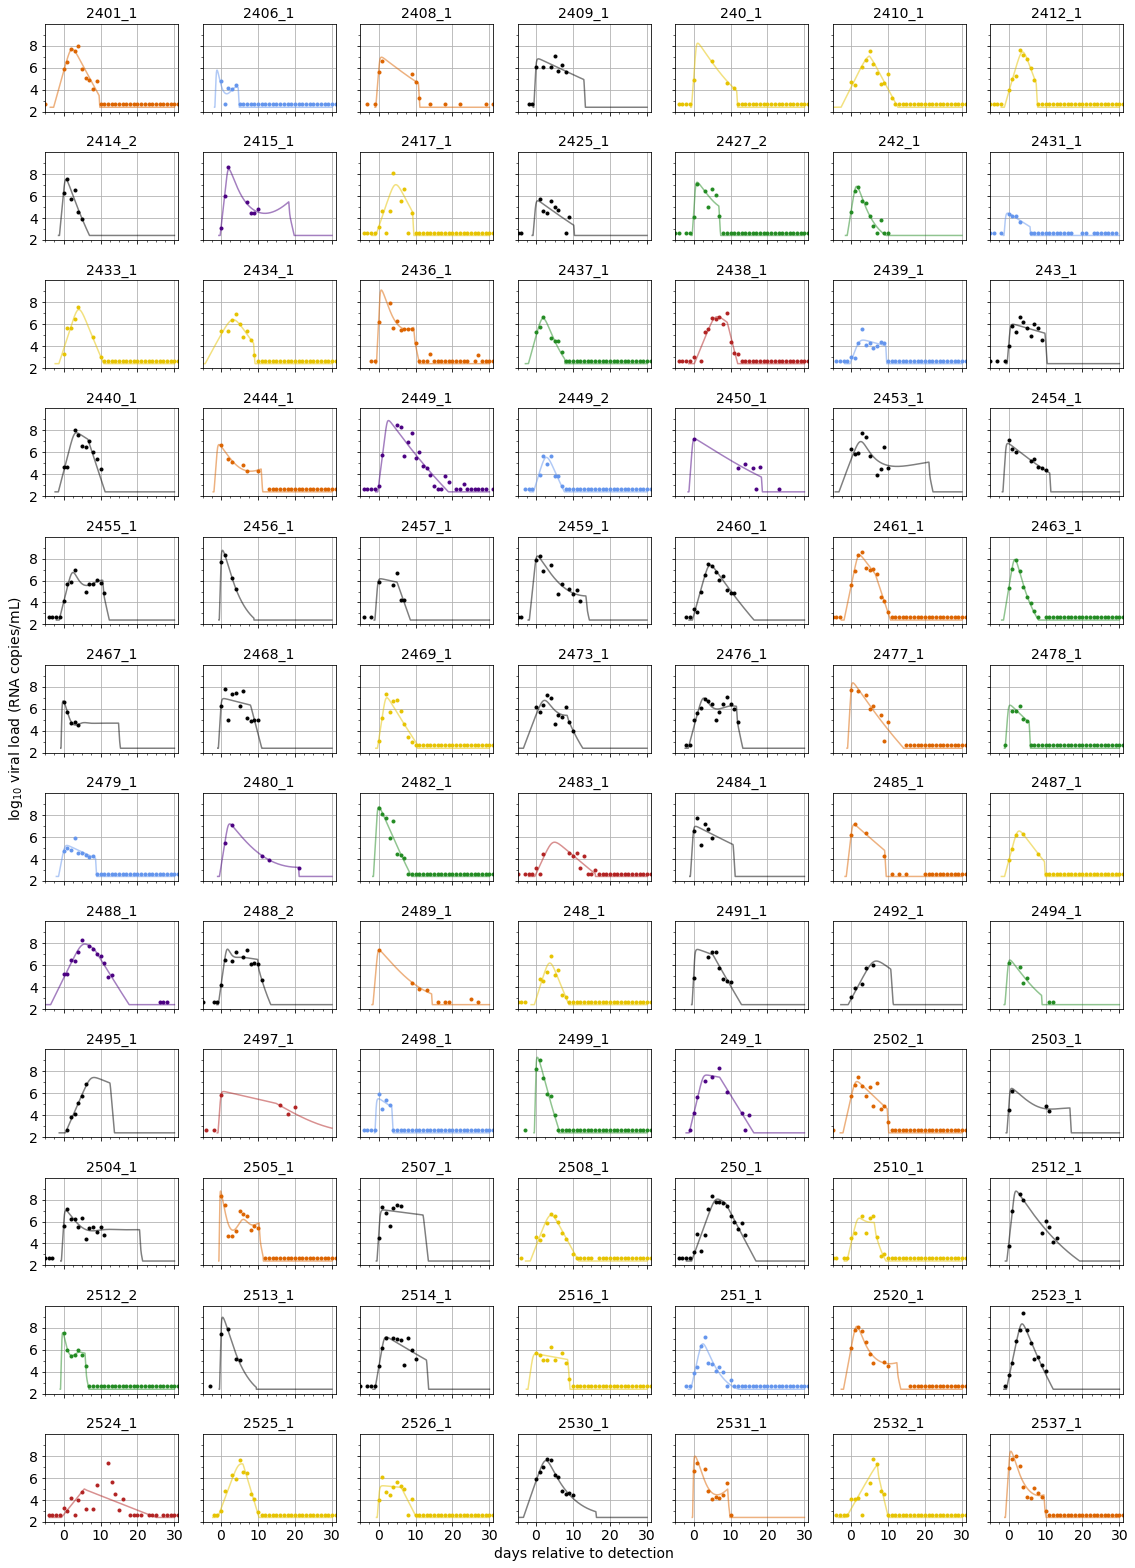

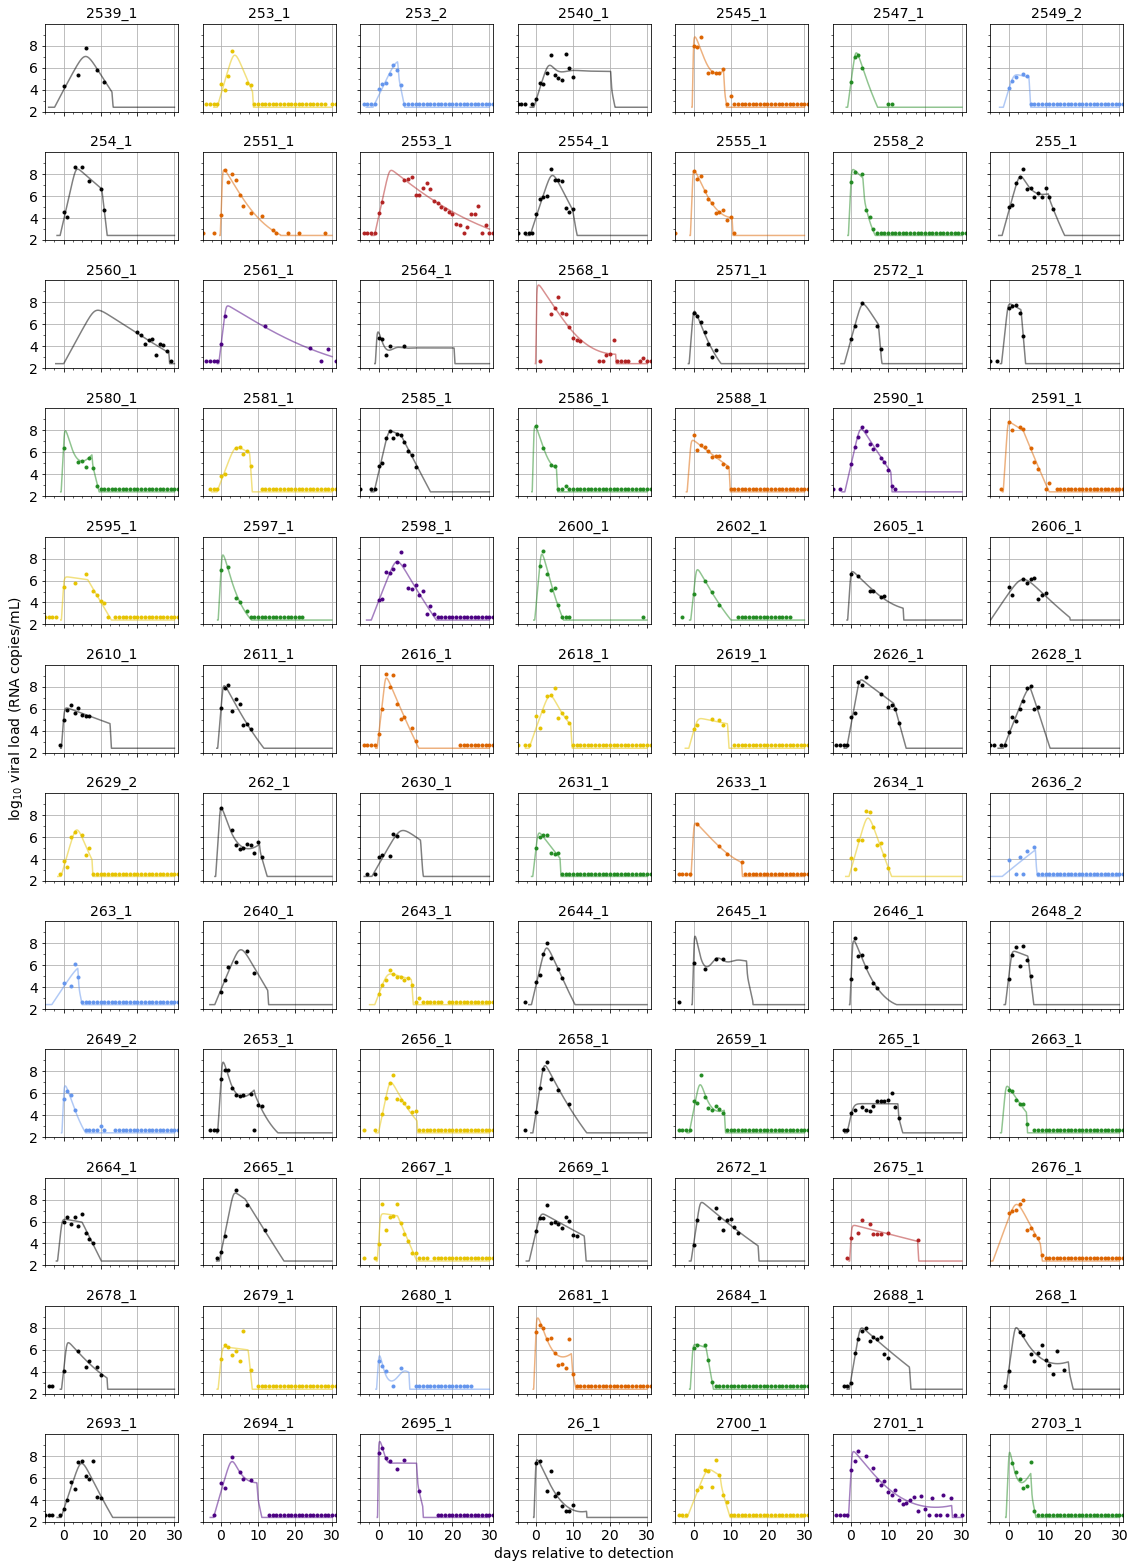

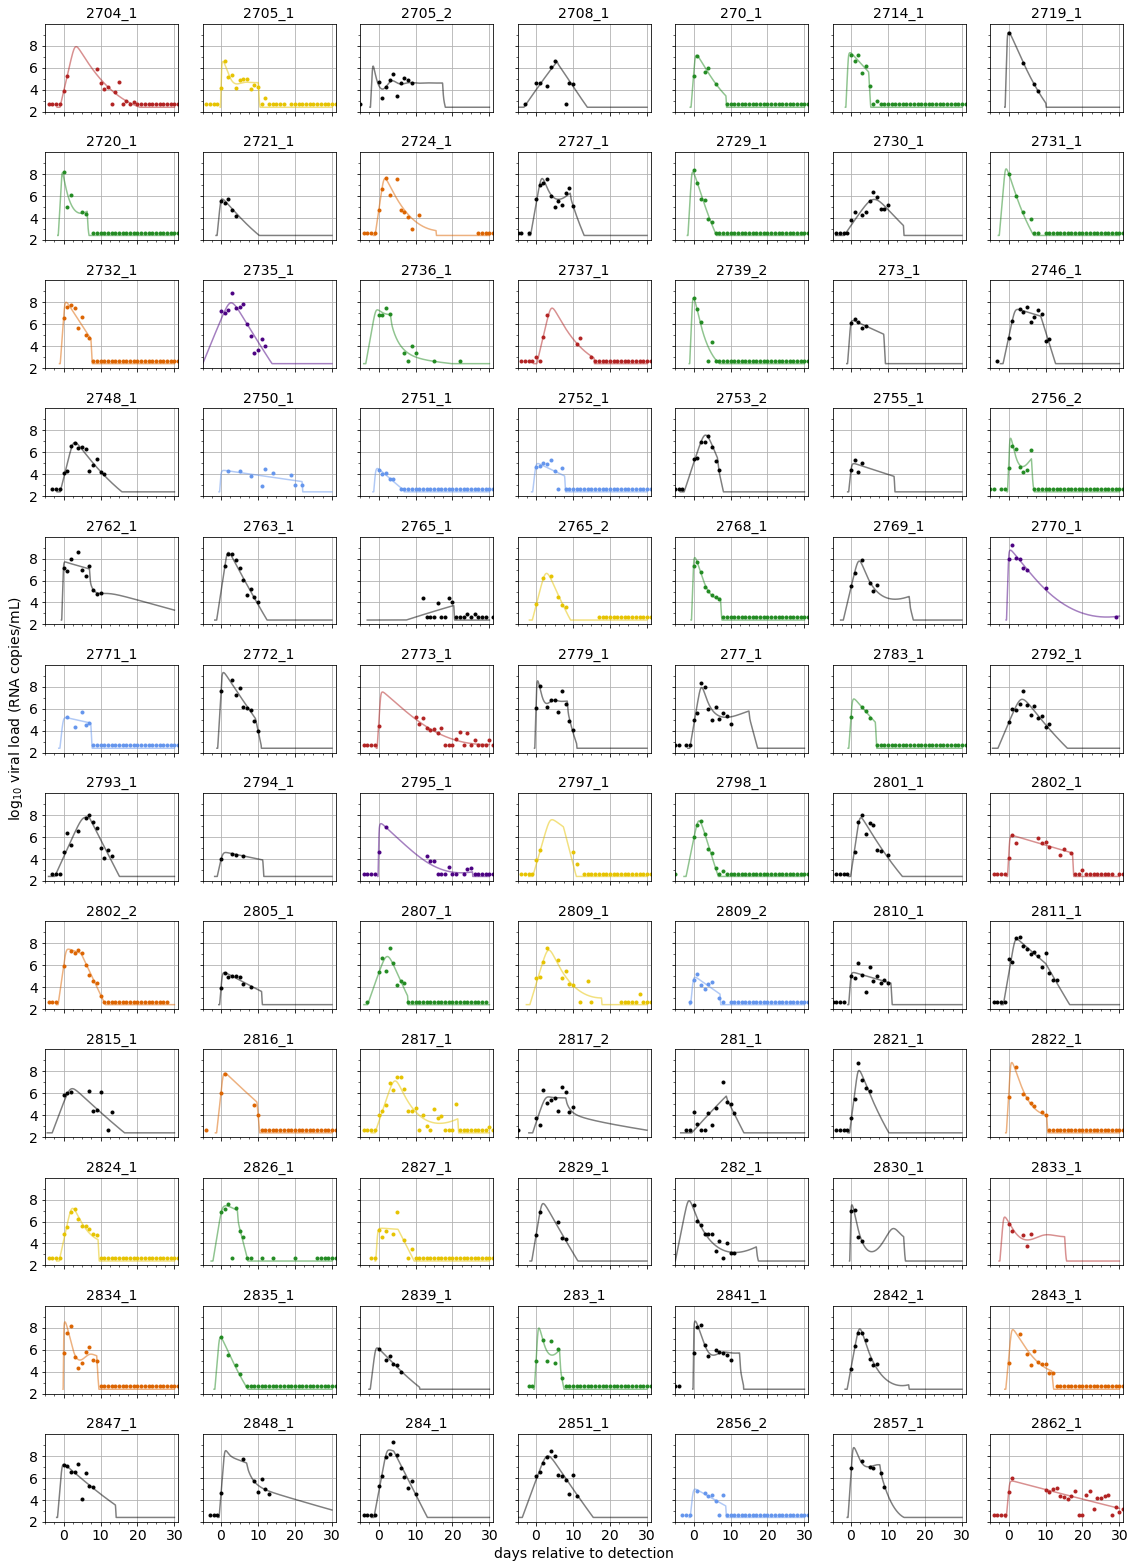

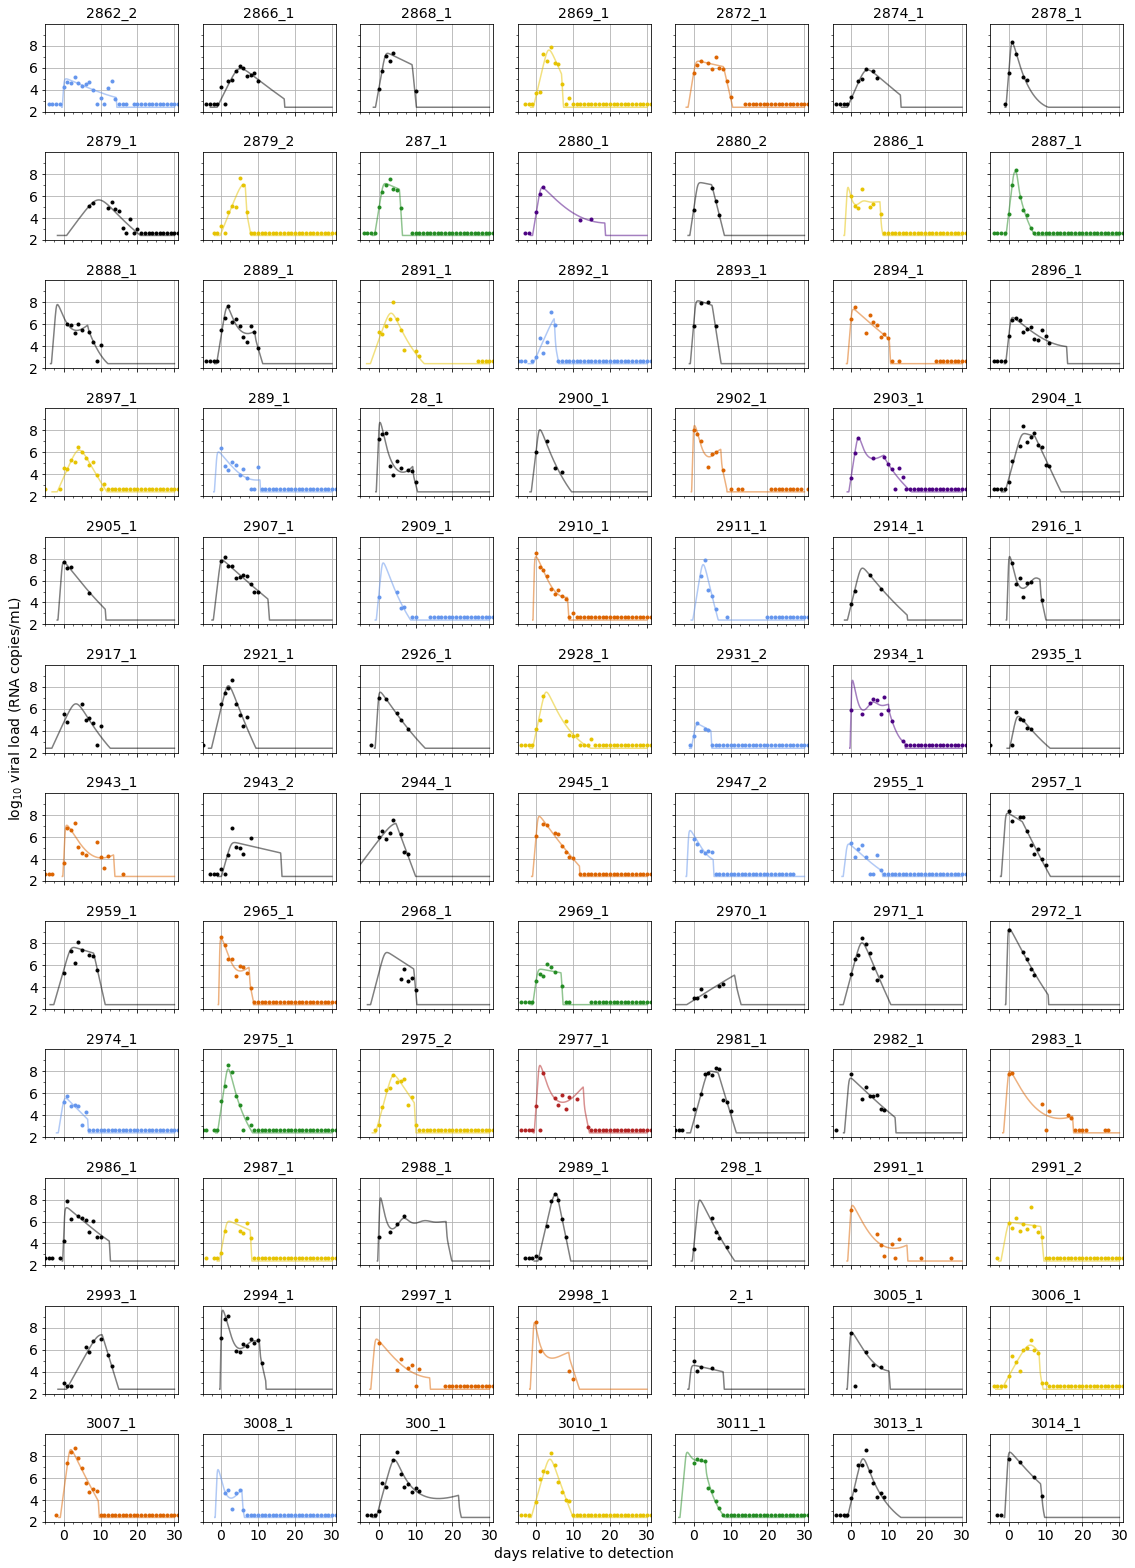

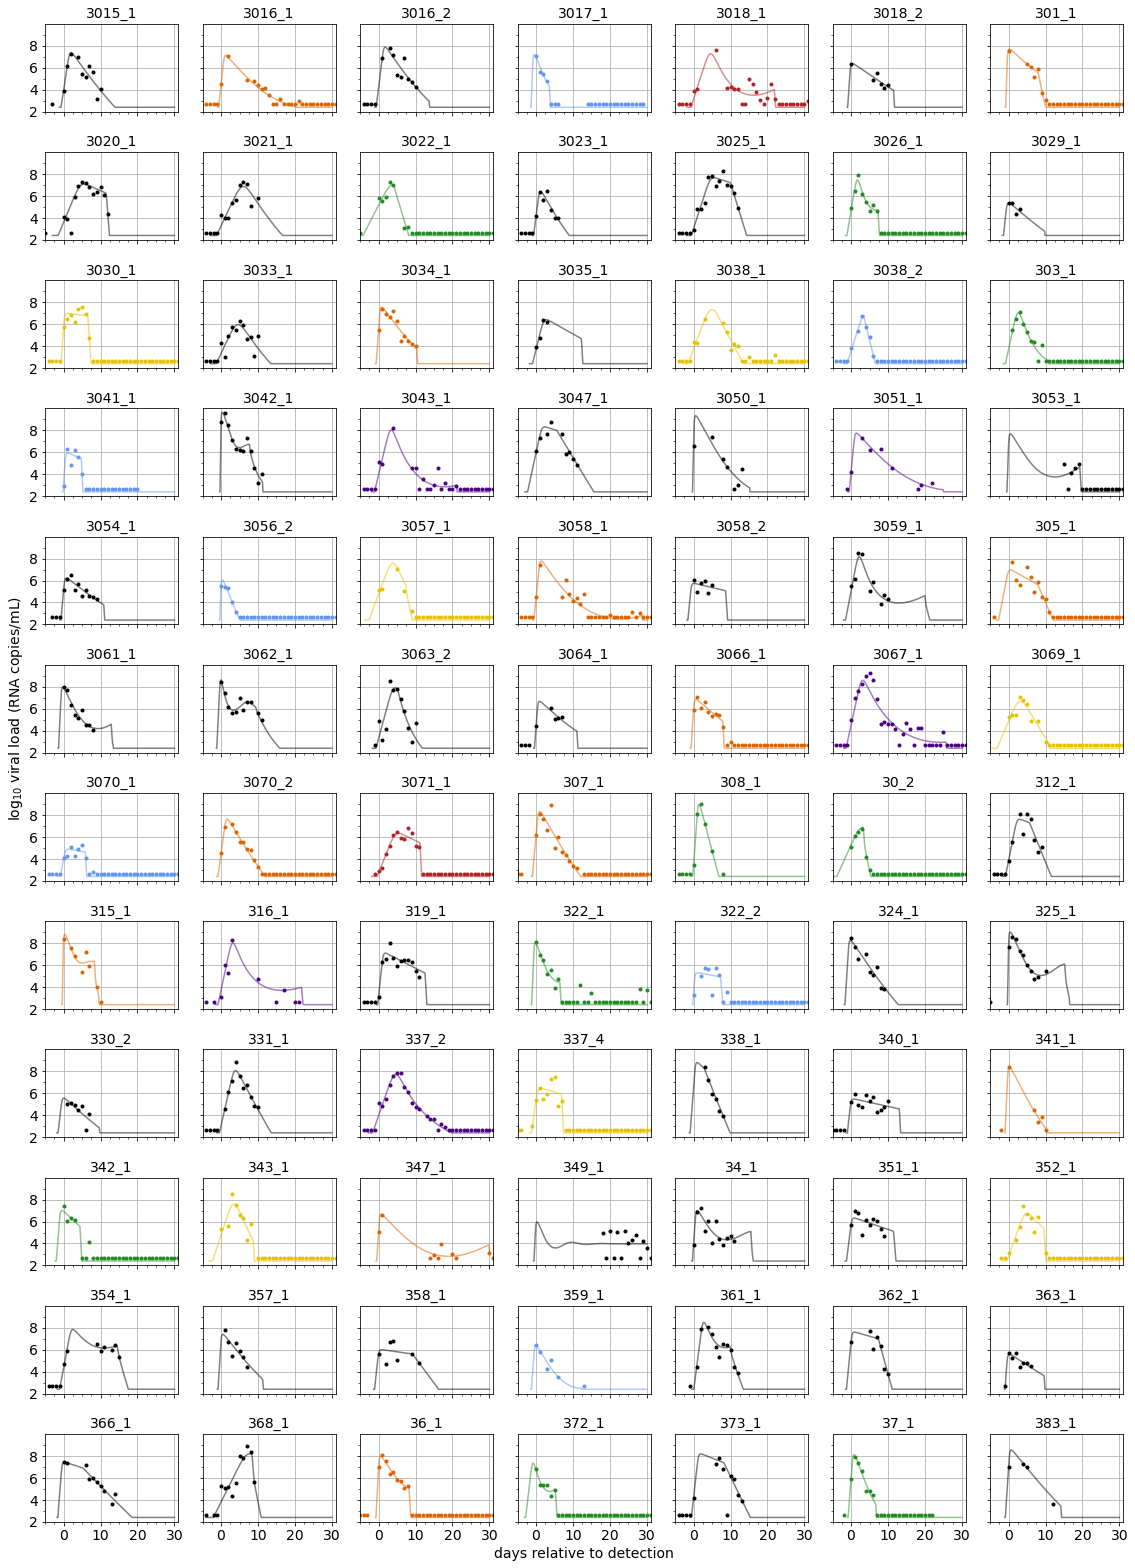

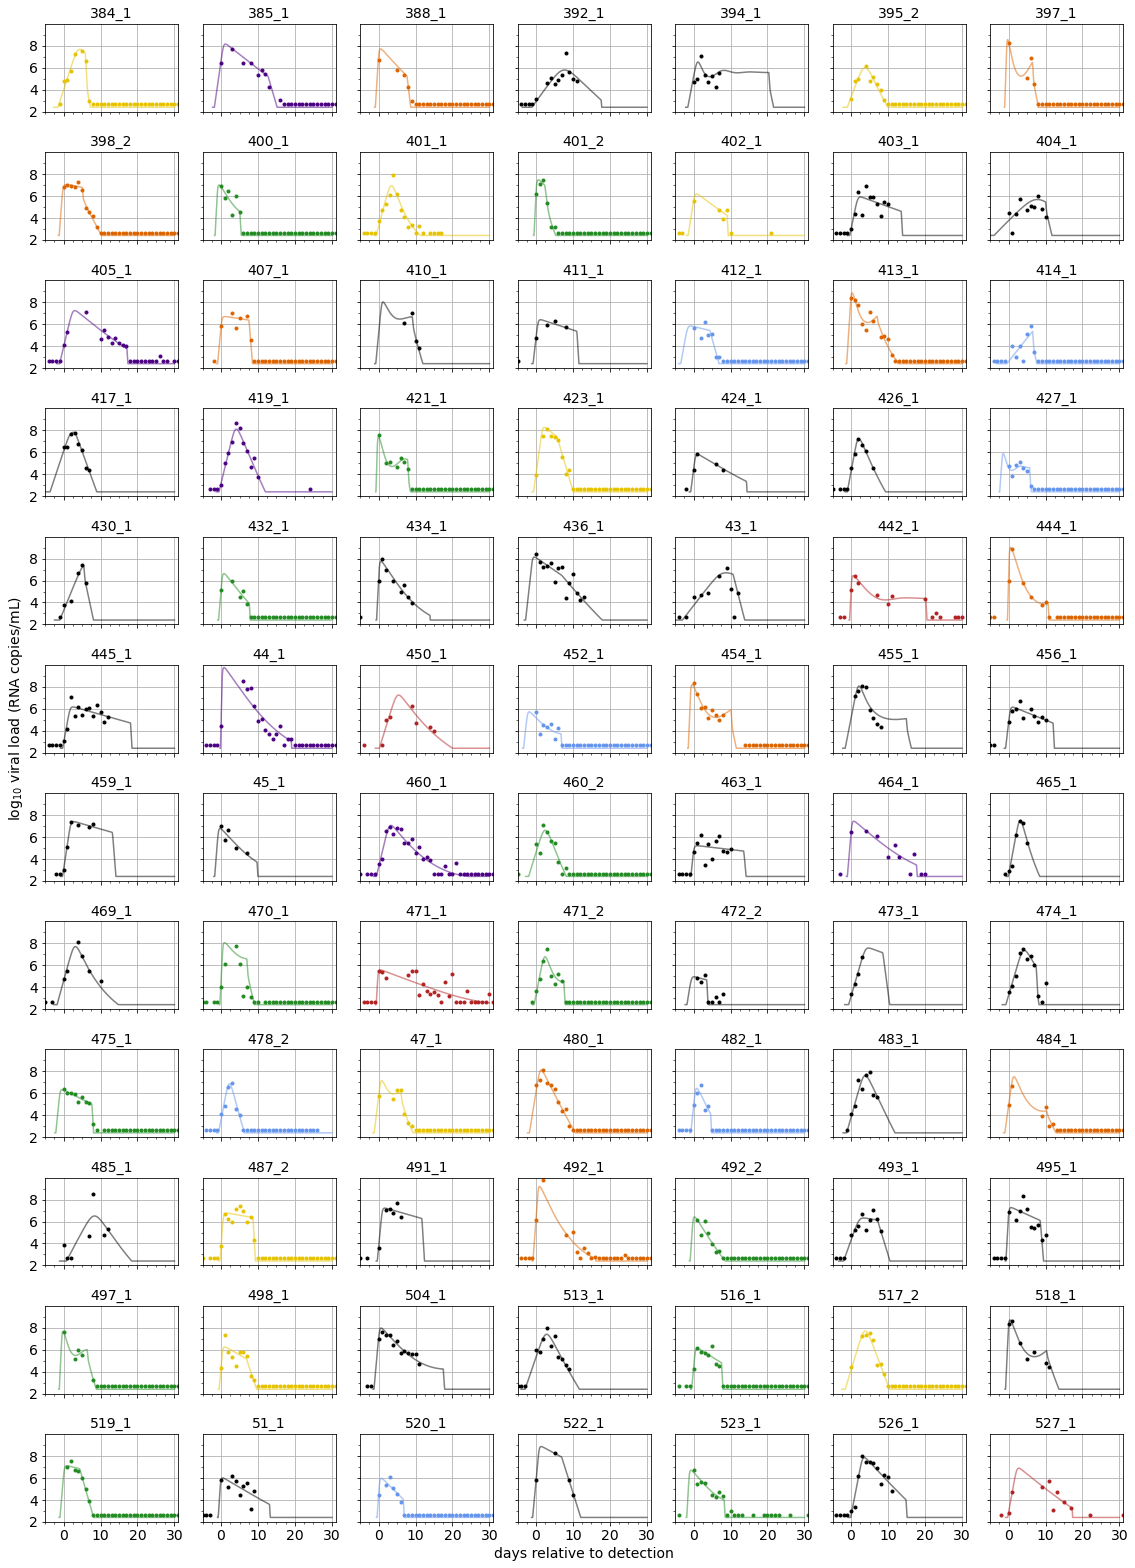

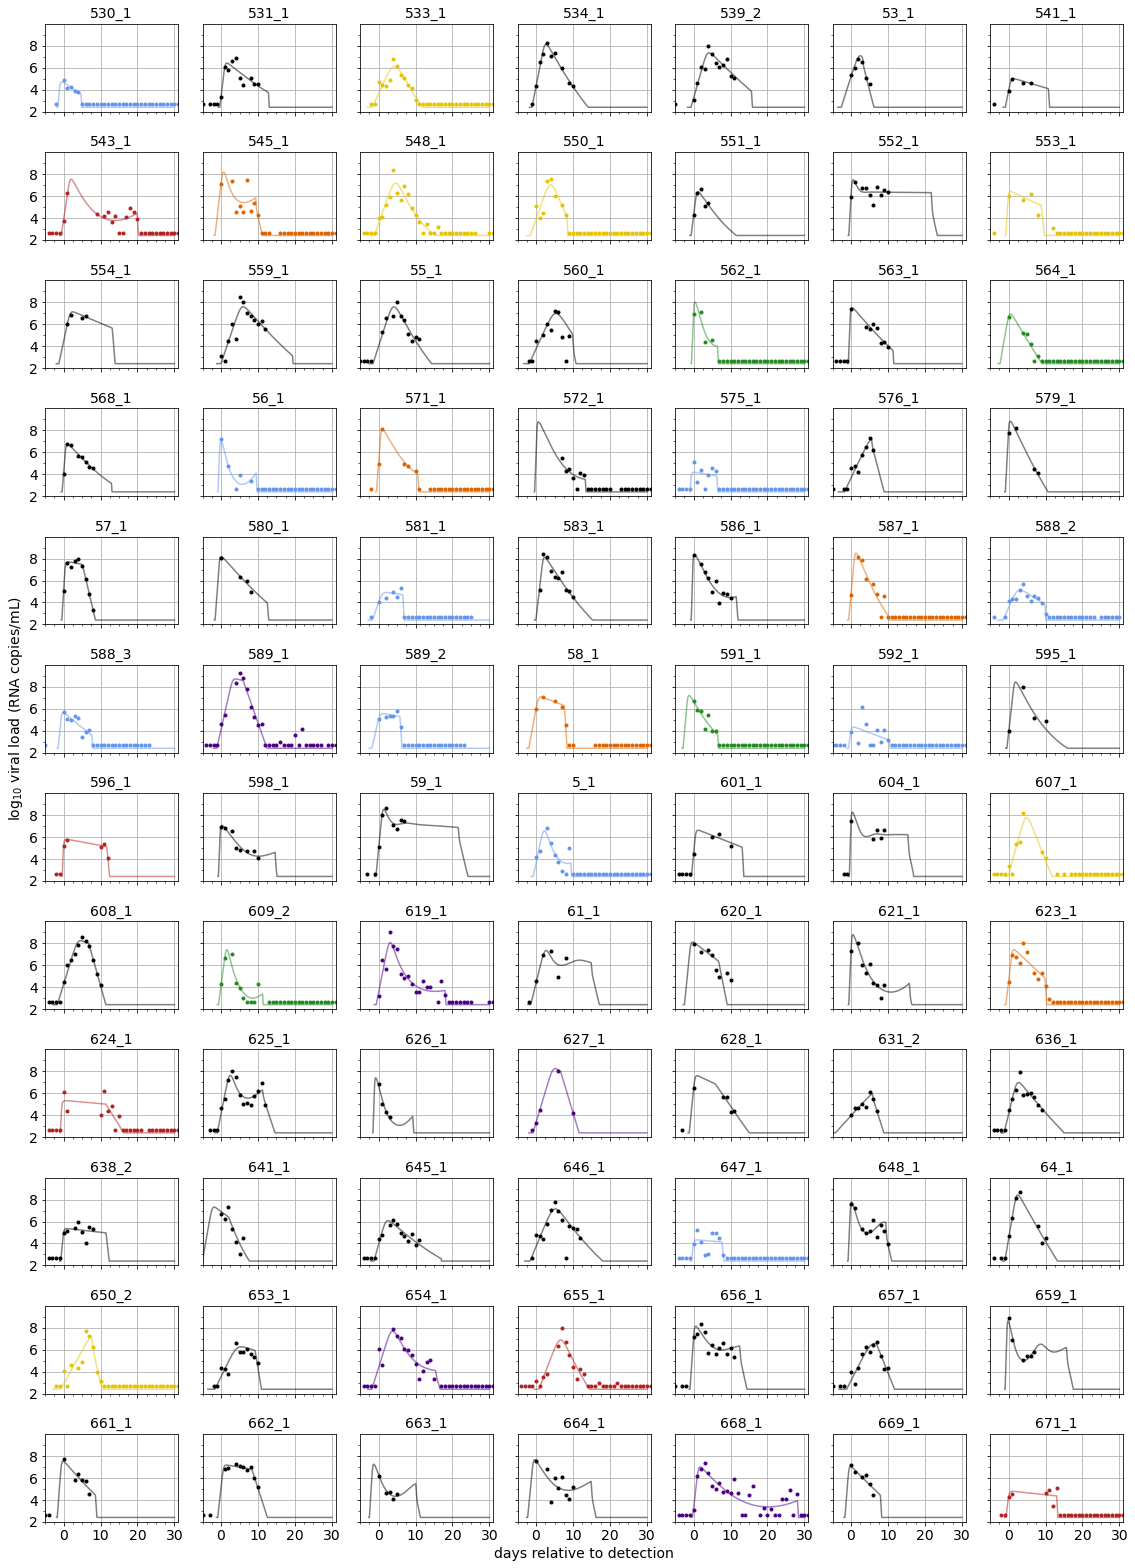

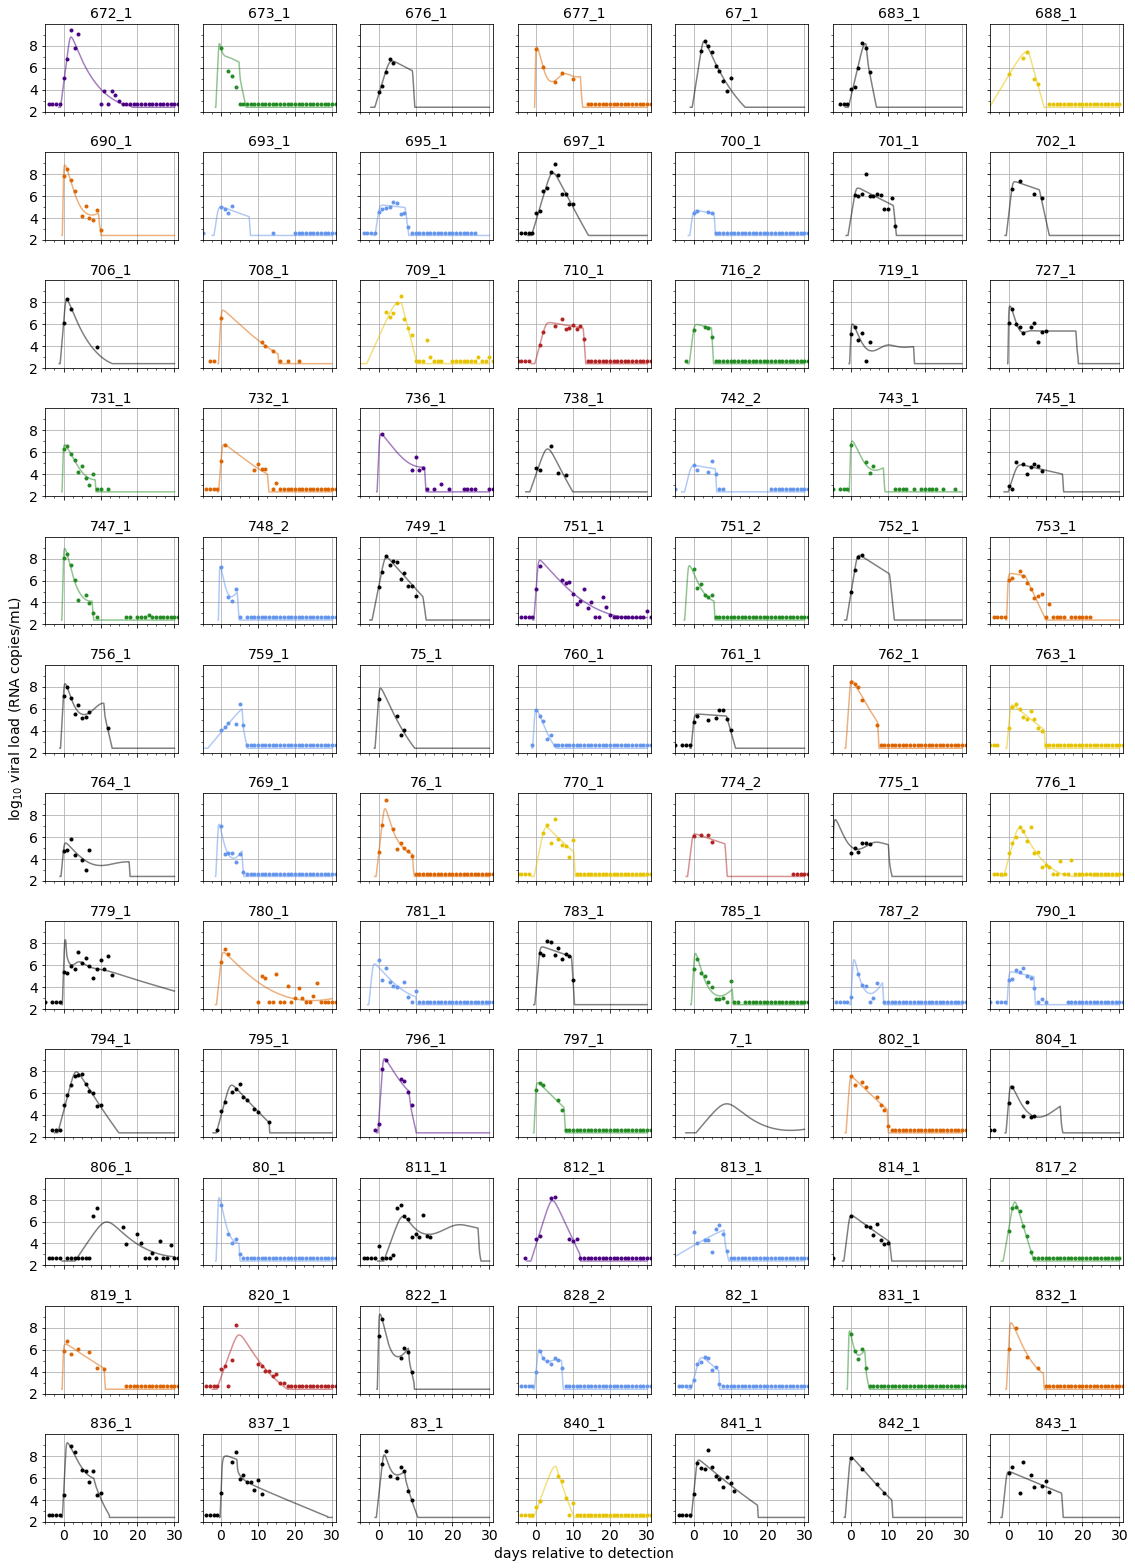

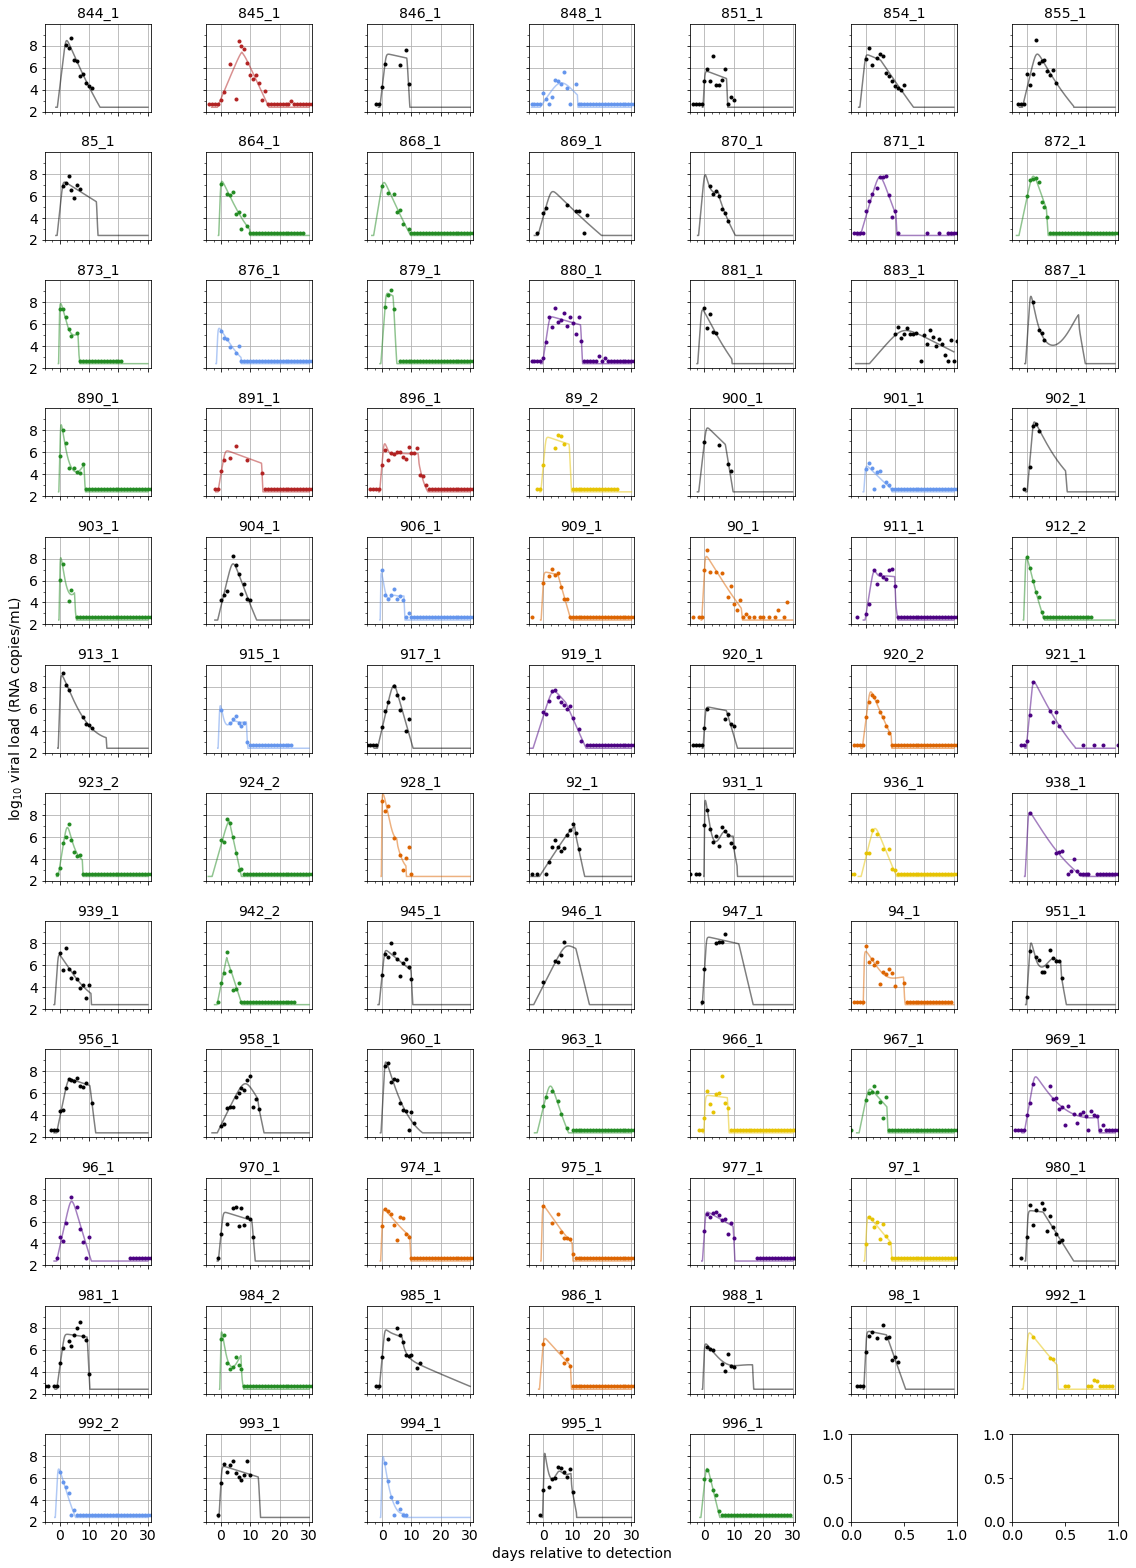

In [5]:
# Plot data and model predictions for all
total = len(IDs_total)
plt.rcParams.update({'font.size': 14})
starts = np.arange(0,total,84);
fnames = ['page' + str(num) +'.png' for num in np.arange(0,20)]

for count,fname in zip(starts, fnames):
    fig, ax = plt.subplots(12,7, figsize =(16,22))
    for j in range(0,12):
        for jj in range(0,7):
            if count < total:
                ID = IDs_total[count]
                ind_params = GetParams(parameters_df, ID, style = 'mode')
                params_dict = {**fixed_params, **ind_params}
                t,y = Simulate(deriv, param_order, params_dict, init, 30, 1000)
                # identify data
                tdata = full_data_df[full_data_df['ID'] == ID].time
                temp = full_data_df[full_data_df['ID'] == ID].y
                cluster = list(parameters_df[parameters_df['id'] == ID].Cluster)[0]
                ydata = [float(y) for y in temp]
                ax[j,jj].plot(tdata.values, ydata,'.', markersize = 6, color = colorDict[cluster])
                ax[j,jj].plot(t, np.log10(np.maximum(y[:,4],250)), color = colorDict[cluster], alpha = 0.5)
                ax[j,jj].set_ylim(2,10)
                ax[j,jj].set_xlim(-5,31)
       
                # Set major ticks for x axis
                major_xticks = np.arange(0, 31, 10)
                # Set major ticks for y axis
                major_yticks = np.arange(2, 10, 2)
                # Set minor ticks for x axis
                minor_xticks = np.arange(-5, 31, 2.5)
                # Set minor ticks for y axis
                minor_yticks = np.arange(2, 10, 1)
                ax[j,jj].set_xticks(major_xticks)
                ax[j,jj].set_xticks(minor_xticks, minor = True)

                ax[j,jj].set_yticks(major_yticks)
                ax[j,jj].set_yticks(minor_yticks, minor = True)
       
                if jj != 0:
                    ax[j,jj].yaxis.set_tick_params(labelleft=False)
                if j != 11:
                    ax[j,jj].xaxis.set_tick_params(labelbottom=False)
                    
                if jj == 0 and j == 5:
                    ax[j,jj].set_ylabel(r'log$_{10}$ viral load (RNA copies/mL)')
                    
                if jj == 3 and j == 11:
                    ax[j,jj].set_xlabel('days relative to detection')
    
                if count < len(IDs_rebound):
                    ax[j,jj].set_title('R: ' + ID , fontsize = 14)
                else:
                    ax[j,jj].set_title(ID , fontsize = 14)
                ax[j,jj].grid()
                count = count+1

    plt.tight_layout()
    #plt.savefig(fname)

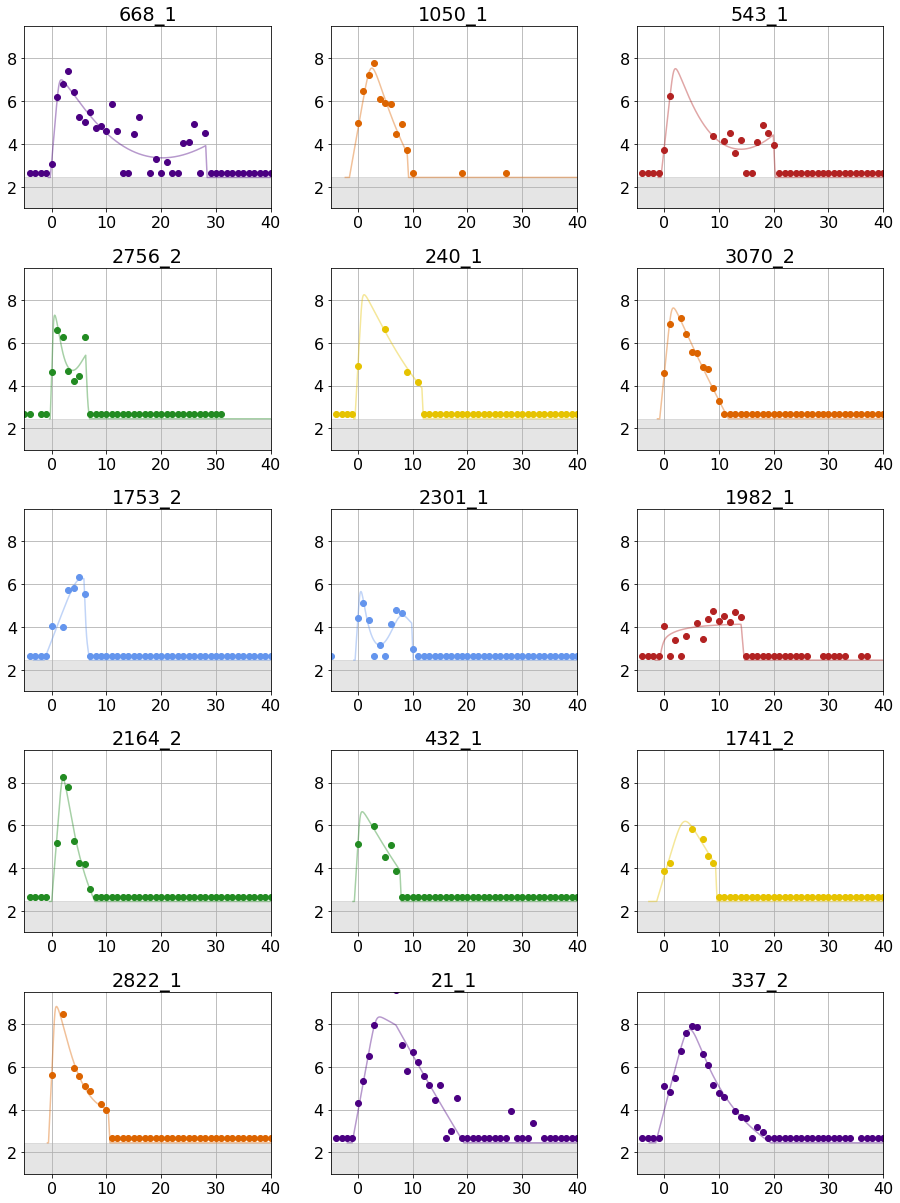

In [6]:
# Plot Examples for main manuscript Fig 3
# Generate plots for Figure 3
ID_fig3 = ['668_1', '1050_1', '543_1', '2756_2', '240_1', '3070_2', 
           '1753_2','2301_1', '1982_1', '2164_2',
           '432_1', '1741_2', '2822_1', '21_1',  '337_2', '2551_1']

plt.rcParams.update({'font.size': 16})
count = 0
fig, ax = plt.subplots(5,3, figsize =(13,17))
for j in range(0,5):
    for jj in range(0,3):
        ID = ID_fig3[count]
        ind_params = GetParams(parameters_df, ID, style = 'mode')
        params_dict = {**fixed_params, **ind_params}
        t,y = Simulate(deriv, param_order, params_dict, init, 40, 10000)
        # identify data
        tdata = data_df[data_df['ID'] == ID].time
        temp = data_df[data_df['ID'] == ID].y
        cluster = list(data_df[data_df['ID'] == ID].Cluster)[0]
        ydata = [float(y) for y in temp]
        ax[j,jj].plot(tdata.values, ydata,'o', color = colorDict[cluster])
        ax[j,jj].plot(t, np.log10(np.maximum(y[:,4],280)), color = colorDict[cluster], alpha = 0.4)
        ax[j,jj].fill_between(np.arange(-5,45), np.log10(280)*np.ones(len(np.arange(-5,45))),np.zeros(len(np.arange(-5,45))),color ='tab:gray',alpha = .2)
        ax[j,jj].set_ylim(1,9.5)
        ax[j,jj].set_xlim(-5,40)
        ax[j,jj].set_title(ID)
        ax[j,jj].grid()
        count = count+1

plt.tight_layout()

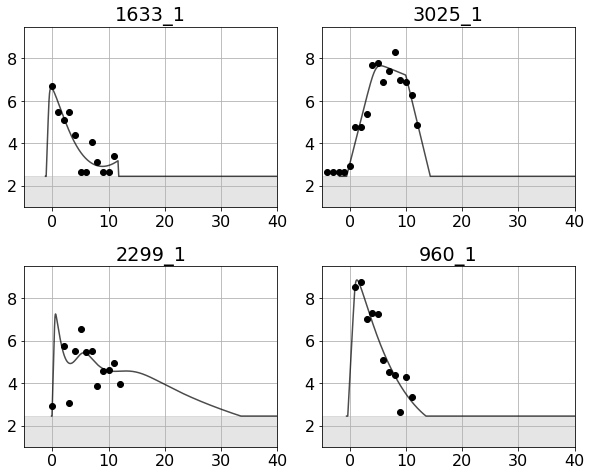

In [7]:
Na_ID = ['1633_1',  '3025_1',  '2299_1','960_1']
na_IDs = [i for i in full_data_df.ID.unique() if i not in IDs_clustered]
plt.rcParams.update({'font.size': 16})
count = 0
fig, ax = plt.subplots(2,2, figsize =(8.5,6.9))
for j in range(0,2):
    for jj in range(0,2):
        ID = Na_ID[count]
        ind_params = GetParams(parameters_df, ID, style = 'mode')
        params_dict = {**fixed_params, **ind_params}
        t,y = Simulate(deriv, param_order, params_dict, init, 40, 10000)
        # identify data
        tdata = full_data_df[full_data_df['ID'] == ID].time
        temp = full_data_df[full_data_df['ID'] == ID].y
        ydata = [float(y) for y in temp]
        ax[j,jj].plot(tdata.values, ydata,'o', color = 'k')
        ax[j,jj].plot(t, np.log10(np.maximum(y[:,4],280)), color = 'k', alpha = 0.7)
        ax[j,jj].fill_between(np.arange(-5,45), np.log10(280)*np.ones(len(np.arange(-5,45))),np.zeros(len(np.arange(-5,45))),color ='tab:gray',alpha = .2)
        ax[j,jj].set_ylim(1,9.5)
        ax[j,jj].set_xlim(-5,40)
        ax[j,jj].set_title(ID)
        ax[j,jj].grid()
        count = count+1

plt.tight_layout()